# Introduction

The term mechanistic model describes a model that is based on fundamental laws of natural sciences.

In the domain of mRNA half-life prediction, one such law is a simplified equation describing the reaction rate of an mRNA with some degradation factor (i.e. some RNA-binding protein or RBP that contributes to degradation of the bound RNA).
This simplified equation states that the half-life of the mRNA is proportional to the binding probability of the mRNA with the degradation factor, multiplied by the concentration of both molecules in some medium.
Of course, there are other influences on mRNA half-life and the equation has to be applied to a range of degradation factors that are all possibly influencing mRNA half-life at the same time.

In the following, we will fit, evaluate and interpret some mechanistic models that try to exploit this relationship.

The desired result of this approach isn't a model with particularly high prediction capabilities, but rather to gain some hints about biological phenomena by interpreting the model, i.e. to analyze the fitted coefficients.
With respect to the tissue-specific data we're working with, this could lead to discovery of varying concentrations of RNA-binding proteins in different tissue types.

# Intuition

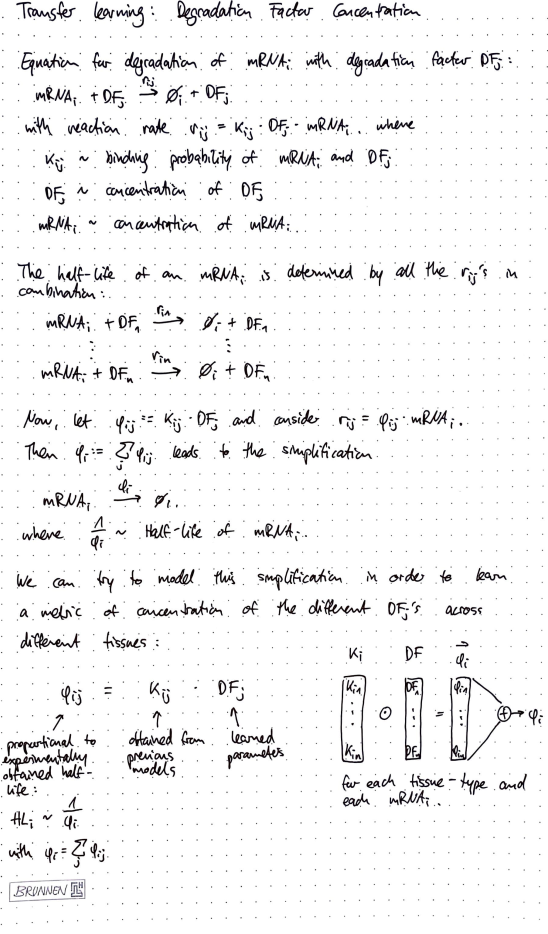

# Setup

## Imports & Setup

In this section, all the libraries are imported, the data is loaded and the basic dataframes are filled.

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd

import statsmodels.api as sm
from sklearn.metrics import r2_score

from plotnine import *
import seaborn as sns
from matplotlib import pyplot as plt

import random
import warnings # to suppress plotnine warnings

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We're setting seeds to provide reproducibility and disabling the warnings we get from the plotnine library:

In [ ]:
random.seed(42)
np.random.seed(42)

In [ ]:
# suppress plotnine warnings
warnings.filterwarnings('ignore')

The data will be loaded from Google Drive:

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation

The `hl_data` dataframe contains measures of relative half-life across different tissue types for different genes, as well as some basic features calculated from the genes sequence:

In [ ]:
hl_data = pd.read_csv('/content/drive/MyDrive/01_multi-tissue_mRNA_half-life/data/delta_hl_gtex.csv')
hl_data = hl_data.rename(columns={"Unnamed: 0": "Gene_ID"})
hl_data

Gene_ID  Adipose_Subcutaneous  Adipose_Visceral_Omentum  \
0      ENST00000000233.5              0.134752                 -0.182582   
1      ENST00000000412.3             -0.376770                 -0.041240   
2      ENST00000000442.6             -0.726338                  0.012830   
3      ENST00000001008.4             -0.216329                 -0.418912   
4      ENST00000001146.2             -0.069316                 -0.412832   
...                  ...                   ...                       ...   
11358  ENST00000609438.1              0.864704                 -0.300802   
11359  ENST00000610125.1              0.779372                  0.292705   
11360  ENST00000610153.1             -0.559951                 -0.078922   
11361  ENST00000610180.1              0.260419                 -0.025293   
11362  ENST00000610189.1              0.113384                  0.207732   

       Adrenal_Gland  Artery_Aorta  Artery_Coronary  Artery_Tibial  \
0          -0.049505      0.320368         0.235287       0.704439   
1          -0.345812      0.081481         0.060310       0.294355   
2           0.067338      0.388878         0.263188       0.631595   
3           0.492567     -0.115684         0.095624       0.155862   
4           0.135867     -0.918034        -0.817979       0.063308   
...              ...           ...              ...            ...   
11358       2.012476     -0.420676         0.265105       0.185818   
11359       0.745689      0.860292         0.873348       1.386361   
11360      -0.443894     -0.237011        -0.299037      -0.138185   
11361       0.272604     -0.251867        -0.141874      -0.100653   
11362       0.182043      0.298952         0.242615       0.615188   

       Brain_Amygdala  Brain_Anterior_cingulate_cortex_BA24  \
0            0.567214                              0.582717   
1                 NaN                                   NaN   
2            0.387595                              0.527506   
3            0.416093                              0.612101   
4            0.943322                              0.641877   
...               ...                                   ...   
11358        1.054606                              0.859654   
11359             NaN                                   NaN   
11360        1.603458                              1.552232   
11361       -0.467802                             -0.475652   
11362       -0.171817                             -0.125229   

       Brain_Caudate_basal_ganglia  ...       TCG       TCT  TGA       TGC  \
0                         0.374816  ...  0.005556  0.005556  0.0  0.000000   
1                         0.535327  ...  0.000000  0.010830  0.0  0.018051   
2                         0.289399  ...  0.007092  0.007092  0.0  0.014184   
3                         0.292338  ...  0.002179  0.013072  0.0  0.006536   
4                        -0.780068  ...  0.007812  0.001953  0.0  0.013672   
...                            ...  ...       ...       ...  ...       ...   
11358                    -0.500367  ...  0.003866  0.034794  0.0  0.009021   
11359                          NaN  ...  0.000000  0.009709  0.0  0.000000   
11360                     1.201373  ...  0.002786  0.033426  0.0  0.005571   
11361                    -0.242697  ...  0.004132  0.012397  0.0  0.016529   
11362                    -0.426107  ...  0.005348  0.016043  0.0  0.002674   

            TGG       TGT       TTA       TTC       TTG       TTT  
0      0.022222  0.011111  0.005556  0.022222  0.011111  0.016667  
1      0.014440  0.014440  0.014440  0.025271  0.007220  0.025271  
2      0.004728  0.011820  0.002364  0.021277  0.004728  0.002364  
3      0.008715  0.004357  0.006536  0.013072  0.002179  0.028322  
4      0.011719  0.000000  0.000000  0.039062  0.011719  0.011719  
...         ...       ...       ...       ...       ...       ...  
11358  0.003866  0.012887  0.006443  0.009021  0.007732  0.007732  
11359  0.000000  0.000000

The `rbp_names` dataframe contains the names of the different RBPs we're considering:

In [ ]:
rbp_names = pd.read_csv('/content/drive/MyDrive/01_multi-tissue_mRNA_half-life/data/RBPs_names_order.csv', header=None)
rbp_names = rbp_names.rename(columns={1: "name"}).drop(0, axis=1)
rbp_names

name
0       DND1
1      CPSF7
2      CPSF6
3      CPSF1
4      CSTF2
5     CSTF2T
6     ZC3H7B
7   FMR1iso1
8      RBM10
9      MOV10
10    ELAVL1
11    TARDBP
12    ELAVL2
13    ELAVL3
14    ELAVL4
15     RBM20
16   IGF2BP1
17   IGF2BP2
18   IGF2BP3
19     EWSR1
20    HNRNPD
21     RBPMS
22     SRRM4
23      AGO2
24    NUDT21
25    FIP1L1
26   CAPRIN1
27  FMR1iso7
28      FXR2
29      AGO1
30     L1RE1
31      ORF1
32     MBNL1
33  P53_NONO
34      PUM2
35       QKI
36      AGO3
37       FUS
38     TAF15
39     ZFP36
40    DICER1
41     EIF3A
42     EIF3D
43     EIF3G
44       SSB
45     PAPD5
46     CPSF4
47     CPSF3
48      RTCB
49      FXR1
50     NOP58
51     NOP56
52       FBL
53    LIN28A
54    LIN28B
55      UPF1
56       G35
57       G45
58      XPO5

The binding scores of the different RBPs per mRNA are stored in the `binding_scores` dataframe:

In [ ]:
K_val = np.load('/content/drive/MyDrive/01_multi-tissue_mRNA_half-life/data/RBP_k_delta_hl.npy')
binding_scores = pd.DataFrame(data=K_val, columns=rbp_names["name"])
binding_scores

name       DND1     CPSF7     CPSF6     CPSF1     CSTF2    CSTF2T    ZC3H7B  \
0      0.466009  0.333622  0.437288  0.385020  0.381856  0.370452  0.055800   
1      0.625239  0.308348  0.366766  0.374922  0.399072  0.512726  0.335513   
2      0.521459  0.290612  0.447987  0.389843  0.095973  0.143399  0.218086   
3      0.709262  0.355740  0.485750  0.256741  0.244642  0.286161  0.191769   
4      0.662297  0.495711  0.456778  0.332413  0.482072  0.725908  0.260003   
...         ...       ...       ...       ...       ...       ...       ...   
11358  0.717967  0.401125  0.477838  0.478471  0.503547  0.741456  0.651293   
11359  0.133103  0.310725  0.417229  0.242206  0.082878  0.103396  0.062475   
11360  0.532119  0.455366  0.412922  0.208121  0.543813  0.696797  0.232554   
11361  0.478198  0.434359  0.433893  0.344058  0.177356  0.246209  0.144415   
11362  0.439113  0.512813  0.419897  0.352287  0.183963  0.234114  0.212331   

name   FMR1iso1     RBM10     MOV10  ...      FXR1     NOP58     NOP56  \
0      0.295653  0.463529  0.306574  ...  0.089381  0.130150  0.134894   
1      0.429682  0.547450  0.476546  ...  0.222410  0.493327  0.239549   
2      0.197878  0.787376  0.395925  ...  0.035236  0.245104  0.125485   
3      0.450174  0.462189  0.425212  ...  0.096333  0.373058  0.126466   
4      0.300501  0.653451  0.445841  ...  0.147800  0.551409  0.295072   
...         ...       ...       ...  ...       ...       ...       ...   
11358  0.353836  0.550075  0.565889  ...  0.394178  0.556764  0.710953   
11359  0.362782  0.312279  0.284507  ...  0.055160  0.252344  0.271547   
11360  0.333743  0.595640  0.406836  ...  0.271856  0.779085  0.259617   
11361  0.301631  0.774920  0.367716  ...  0.134948  0.563118  0.123267   
11362  0.393941  0.804548  0.559419  ...  0.197310  0.435693  0.198299   

name        FBL    LIN28A    LIN28B      UPF1       G35       G45      XPO5  
0      0.362862  0.185488  0.101833  0.075934  0.304871  0.262849  0.198160  
1      0.422607  0.300081  0.511566  0.212465  0.139636  0.303893  0.337837  
2      0.679963  0.214952  0.816133  0.078845  0.143686  0.205081  0.172913  
3      0.430117  0.402916  0.186499  0.149575  0.314400  0.504436  0.198861  
4      0.566890  0.398808  0.273079  0.215787  0.294323  0.403959  0.424652  
...         ...       ...       ...       ...       ...       ...       ...  
11358  0.380614  0.368731  0.737023  0.309320  0.275847  0.514541  0.471805  
11359  0.245479  0.271669  0.165971  0.033851  0.163344  0.419075  0.223508  
11360  0.393854  0.250726  0.507322  0.195718  0.238335  0.237361  0.378352  
11361  0.628366  0.436823  0.101388  0.334520  0.164246  0.214602  0.243445  
11362  0.439418  0.233155  0.176489  0.239051  0.226289  0.236632  0.348496  

[11363 rows x 59 columns]

Finally, we're joining the `hl_data` and the `binding_scores` dataframe to obtain a single dataframe:

In [ ]:
data = hl_data.join(binding_scores)
data

Gene_ID  Adipose_Subcutaneous  Adipose_Visceral_Omentum  \
0      ENST00000000233.5              0.134752                 -0.182582   
1      ENST00000000412.3             -0.376770                 -0.041240   
2      ENST00000000442.6             -0.726338                  0.012830   
3      ENST00000001008.4             -0.216329                 -0.418912   
4      ENST00000001146.2             -0.069316                 -0.412832   
...                  ...                   ...                       ...   
11358  ENST00000609438.1              0.864704                 -0.300802   
11359  ENST00000610125.1              0.779372                  0.292705   
11360  ENST00000610153.1             -0.559951                 -0.078922   
11361  ENST00000610180.1              0.260419                 -0.025293   
11362  ENST00000610189.1              0.113384                  0.207732   

       Adrenal_Gland  Artery_Aorta  Artery_Coronary  Artery_Tibial  \
0          -0.049505      0.320368         0.235287       0.704439   
1          -0.345812      0.081481         0.060310       0.294355   
2           0.067338      0.388878         0.263188       0.631595   
3           0.492567     -0.115684         0.095624       0.155862   
4           0.135867     -0.918034        -0.817979       0.063308   
...              ...           ...              ...            ...   
11358       2.012476     -0.420676         0.265105       0.185818   
11359       0.745689      0.860292         0.873348       1.386361   
11360      -0.443894     -0.237011        -0.299037      -0.138185   
11361       0.272604     -0.251867        -0.141874      -0.100653   
11362       0.182043      0.298952         0.242615       0.615188   

       Brain_Amygdala  Brain_Anterior_cingulate_cortex_BA24  \
0            0.567214                              0.582717   
1                 NaN                                   NaN   
2            0.387595                              0.527506   
3            0.416093                              0.612101   
4            0.943322                              0.641877   
...               ...                                   ...   
11358        1.054606                              0.859654   
11359             NaN                                   NaN   
11360        1.603458                              1.552232   
11361       -0.467802                             -0.475652   
11362       -0.171817                             -0.125229   

       Brain_Caudate_basal_ganglia  ...      FXR1     NOP58     NOP56  \
0                         0.374816  ...  0.089381  0.130150  0.134894   
1                         0.535327  ...  0.222410  0.493327  0.239549   
2                         0.289399  ...  0.035236  0.245104  0.125485   
3                         0.292338  ...  0.096333  0.373058  0.126466   
4                        -0.780068  ...  0.147800  0.551409  0.295072   
...                            ...  ...       ...       ...       ...   
11358                    -0.500367  ...  0.394178  0.556764  0.710953   
11359                          NaN  ...  0.055160  0.252344  0.271547   
11360                     1.201373  ...  0.271856  0.779085  0.259617   
11361                    -0.242697  ...  0.134948  0.563118  0.123267   
11362                    -0.426107  ...  0.197310  0.435693  0.198299   

            FBL    LIN28A    LIN28B      UPF1       G35       G45      XPO5  
0      0.362862  0.185488  0.101833  0.075934  0.304871  0.262849  0.198160  
1      0.422607  0.300081  0.511566  0.212465  0.139636  0.303893  0.337837  
2      0.679963  0.214952  0.816133  0.078845  0.143686  0.205081  0.172913  
3      0.430117  0.402916  0.186499  0.149575  0.314400  0.504436  0.198861  
4      0.566890  0.398808  0.273079  0.215787  0.294323  0.403959  0.424652  
...         ...       ...       ...       ...       ...       ...       ...  
11358  0.380614  0.368731  0.737023  0.309320  0.275847  0.514541  0.471805  
11359

## Feature Extraction

This combined dataframe now contains the following columns:

In [ ]:
for i, col in enumerate(data.columns):
  print(i, col)

0 Gene_ID
1 Adipose_Subcutaneous
2 Adipose_Visceral_Omentum
3 Adrenal_Gland
4 Artery_Aorta
5 Artery_Coronary
6 Artery_Tibial
7 Brain_Amygdala
8 Brain_Anterior_cingulate_cortex_BA24
9 Brain_Caudate_basal_ganglia
10 Brain_Cerebellar_Hemisphere
11 Brain_Cerebellum
12 Brain_Cortex
13 Brain_Frontal_Cortex_BA9
14 Brain_Hippocampus
15 Brain_Hypothalamus
16 Brain_Nucleus_accumbens_basal_ganglia
17 Brain_Putamen_basal_ganglia
18 Brain_Spinal_cord_cervical_c_1
19 Brain_Substantia_nigra
20 Breast_Mammary_Tissue
21 Cells_EBV_transformed_lymphocytes
22 Cells_Transformed_fibroblasts
23 Colon_Sigmoid
24 Colon_Transverse
25 Esophagus_Gastroesophageal_Junction
26 Esophagus_Mucosa
27 Esophagus_Muscularis
28 Heart_Atrial_Appendage
29 Heart_Left_Ventricle
30 Kidney_Cortex
31 Liver
32 Lung
33 Minor_Salivary_Gland
34 Muscle_Skeletal
35 Nerve_Tibial
36 Ovary
37 Pancreas
38 Pituitary
39 Prostate
40 Skin_Not_Sun_Exposed_Suprapubic
41 Skin_Sun_Exposed_Lower_leg
42 Small_Intestine_Terminal_Ileum
43 Spleen
44 Sto

Out of these features, the first 49 after the Gene ID field are the measures of relative half-life:

In [ ]:
tissue_feat_ids = range(1,50)
tissue_types = pd.DataFrame(data.columns[tissue_feat_ids]).rename(columns={0: "feature"})
tissue_types["category"] = "half-life"
tissue_types

feature   category
0                    Adipose_Subcutaneous  half-life
1                Adipose_Visceral_Omentum  half-life
2                           Adrenal_Gland  half-life
3                            Artery_Aorta  half-life
4                         Artery_Coronary  half-life
5                           Artery_Tibial  half-life
6                          Brain_Amygdala  half-life
7    Brain_Anterior_cingulate_cortex_BA24  half-life
8             Brain_Caudate_basal_ganglia  half-life
9             Brain_Cerebellar_Hemisphere  half-life
10                       Brain_Cerebellum  half-life
11                           Brain_Cortex  half-life
12               Brain_Frontal_Cortex_BA9  half-life
13                      Brain_Hippocampus  half-life
14                     Brain_Hypothalamus  half-life
15  Brain_Nucleus_accumbens_basal_ganglia  half-life
16            Brain_Putamen_basal_ganglia  half-life
17         Brain_Spinal_cord_cervical_c_1  half-life
18                 Brain_Substantia_nigra  half-life
19                  Breast_Mammary_Tissue  half-life
20      Cells_EBV_transformed_lymphocytes  half-life
21          Cells_Transformed_fibroblasts  half-life
22                          Colon_Sigmoid  half-life
23                       Colon_Transverse  half-life
24    Esophagus_Gastroesophageal_Junction  half-life
25                       Esophagus_Mucosa  half-life
26                   Esophagus_Muscularis  half-life
27                 Heart_Atrial_Appendage  half-life
28                   Heart_Left_Ventricle  half-life
29                          Kidney_Cortex  half-life
30                                  Liver  half-life
31                                   Lung  half-life
32                   Minor_Salivary_Gland  half-life
33                        Muscle_Skeletal  half-life
34                           Nerve_Tibial  half-life
35                                  Ovary  half-life
36                               Pancreas  half-life
37                              Pituitary  half-life
38                               Prostate  half-life
39        Skin_Not_Sun_Exposed_Suprapubic  half-life
40             Skin_Sun_Exposed_Lower_leg  half-life
41         Small_Intestine_Terminal_Ileum  half-life
42                                 Spleen  half-life
43                                Stomach  half-life
44                                 Testis  half-life
45                                Thyroid  half-life
46                                 Uterus  half-life
47                                 Vagina  half-life
48                            Whole_Blood  half-life

For easier access, we're saving the tissue types in a global variable:

In [ ]:
tissue_names = tissue_types["feature"]

There are 64 different codon frequencies per mRNA:

In [ ]:
codon_freq_ids = range(61,61+64)
codon_freqs = pd.DataFrame(data.columns[codon_freq_ids]).rename(columns={0: "feature"})
codon_freqs["category"] = "codon_freq"
codon_freqs

feature    category
0      AAA  codon_freq
1      AAC  codon_freq
2      AAG  codon_freq
3      AAT  codon_freq
4      ACA  codon_freq
..     ...         ...
59     TGT  codon_freq
60     TTA  codon_freq
61     TTC  codon_freq
62     TTG  codon_freq
63     TTT  codon_freq

[64 rows x 2 columns]

There are the 59 RBP binding scores per mRNA:

In [ ]:
rbp_score_ids = range(125,184)
rbp_scores = pd.DataFrame(data.columns[rbp_score_ids]).rename(columns={0: "feature"})
rbp_scores["category"] = "rbp_score"
rbp_scores

feature   category
0       DND1  rbp_score
1      CPSF7  rbp_score
2      CPSF6  rbp_score
3      CPSF1  rbp_score
4      CSTF2  rbp_score
5     CSTF2T  rbp_score
6     ZC3H7B  rbp_score
7   FMR1iso1  rbp_score
8      RBM10  rbp_score
9      MOV10  rbp_score
10    ELAVL1  rbp_score
11    TARDBP  rbp_score
12    ELAVL2  rbp_score
13    ELAVL3  rbp_score
14    ELAVL4  rbp_score
15     RBM20  rbp_score
16   IGF2BP1  rbp_score
17   IGF2BP2  rbp_score
18   IGF2BP3  rbp_score
19     EWSR1  rbp_score
20    HNRNPD  rbp_score
21     RBPMS  rbp_score
22     SRRM4  rbp_score
23      AGO2  rbp_score
24    NUDT21  rbp_score
25    FIP1L1  rbp_score
26   CAPRIN1  rbp_score
27  FMR1iso7  rbp_score
28      FXR2  rbp_score
29      AGO1  rbp_score
30     L1RE1  rbp_score
31      ORF1  rbp_score
32     MBNL1  rbp_score
33  P53_NONO  rbp_score
34      PUM2  rbp_score
35       QKI  rbp_score
36      AGO3  rbp_score
37       FUS  rbp_score
38     TAF15  rbp_score
39     ZFP36  rbp_score
40    DICER1  rbp_score
41     EIF3A  rbp_score
42     EIF3D  rbp_score
43     EIF3G  rbp_score
44       SSB  rbp_score
45     PAPD5  rbp_score
46     CPSF4  rbp_score
47     CPSF3  rbp_score
48      RTCB  rbp_score
49      FXR1  rbp_score
50     NOP58  rbp_score
51     NOP56  rbp_score
52       FBL  rbp_score
53    LIN28A  rbp_score
54    LIN28B  rbp_score
55      UPF1  rbp_score
56       G35  rbp_score
57       G45  rbp_score
58      XPO5  rbp_score

There are three sequence-length related features:

In [ ]:
length_features = pd.DataFrame({"feature": ["log_3_utr_length", "log_5_utr_length", "log_cds_length"]})
length_features["category"] = "length"
length_features

feature category
0  log_3_utr_length   length
1  log_5_utr_length   length
2    log_cds_length   length

And finally three features concerning GC-content:

In [ ]:
gc_content_features = pd.DataFrame({"feature": ["gc_content_5_utr", "gc_content_cds", "gc_content_3_utr"]})
gc_content_features["category"] = "gc_content"
gc_content_features

feature    category
0  gc_content_5_utr  gc_content
1    gc_content_cds  gc_content
2  gc_content_3_utr  gc_content

We can combine all these features into one dataframe:

In [ ]:
features = pd.concat([tissue_types, codon_freqs, rbp_scores, length_features, gc_content_features], ignore_index=True)
features

feature    category
0        Adipose_Subcutaneous   half-life
1    Adipose_Visceral_Omentum   half-life
2               Adrenal_Gland   half-life
3                Artery_Aorta   half-life
4             Artery_Coronary   half-life
..                        ...         ...
173          log_5_utr_length      length
174            log_cds_length      length
175          gc_content_5_utr  gc_content
176            gc_content_cds  gc_content
177          gc_content_3_utr  gc_content

[178 rows x 2 columns]

We can now supply functions that extract the relevant feature names and values for a whole (or multiple) feature category:

In [ ]:
def get_feat_names(feature_categories):
  return features.loc[features["category"].isin(feature_categories)]["feature"]

def get_feat_values(data, feat_names):
  return data[feat_names]

def get_all_halflife_values(data):
  feat_names = get_feat_names(["half-life"])
  return get_feat_values(data, feat_names)

# Data Processing

In this section, we're building cross validation folds across chromosomes, as well as examining the outcome variables.

## Cross-Validation on Chromosomes

We will use cross-validation on the chromosomes to evaluate the different models we're fitting.

First we're listing all the different chromosomes that our genes are stemming from:

In [ ]:
pd.unique(data["chromosome"])

array(['chr7', 'chr12', 'chr11', 'chr2', 'chr6', 'chr16', 'chr4', 'chr1',
       'chr19', 'chr17', 'chr8', 'chr3', 'chr14', 'chr20', 'chr13',
       'chr5', 'chr15', 'chrX', 'chr18', 'chr10', 'chr9', 'chr22',
       'chr21', 'chrY'], dtype=object)

Next we're printing the amount of mRNA transcripts we have per chromosome:

In [ ]:
chroms_arr = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY']
chroms = pd.DataFrame({"id": range(len(chroms_arr)), "name": chroms_arr})

for chrom in chroms["name"]:
  print(chrom, len(data.loc[data["chromosome"] == chrom]))

chr1 1192
chr2 733
chr3 622
chr4 421
chr5 540
chr6 573
chr7 514
chr8 394
chr9 461
chr10 439
chr11 672
chr12 584
chr13 187
chr14 366
chr15 348
chr16 542
chr17 674
chr18 146
chr19 848
chr20 313
chr21 103
chr22 284
chrX 399
chrY 8


We want to create CV folds that are mutually exclusive and contain the complete data from a few chromosomes each.
Thus, we're printing the training and test set sizes that are to be achieved (80% and 20% of all data, respectively), including a threshold of 2% in both directions:

In [ ]:
train_proportion = 0.8
tolerance = 0.02
total_size = len(data)
min_train_size = int(len(data) * (train_proportion-tolerance))
max_train_size = int(len(data) * (train_proportion+tolerance))
min_test_size = int(len(data) * (1-train_proportion-tolerance))
max_test_size = int(len(data) * (1-train_proportion+tolerance))

print("Approx. train set size", min_train_size, "-", max_train_size)
print("Approx. test set size", min_test_size, "-", max_test_size)

Approx. train set size 8863 - 9317
Approx. test set size 2045 - 2499


Given this information, we can split the chromosomes into different folds with mutually exclusive test sets and check whether their sizes comply with the desired ratio:

In [ ]:
def check_testset(test_idx):
  test_chroms = chroms.loc[test_idx]["name"].tolist()
  test_size = len(data.loc[data["chromosome"].isin(test_chroms)])
  check = (test_size >= min_test_size and test_size <= max_test_size) # this should suffice
  print("Testing whether", test_chroms, "has size", test_size, "between (", min_test_size, ",", max_test_size, "):", check)
  return check

test_sets = [[0, 1, 21], [2, 4, 5, 6], [7, 8, 9, 10, 12, 23], [11, 13, 14, 15, 17, 19], [16, 18, 20, 3, 22]]
for test_set in test_sets:
  print(test_set)
  check_testset(test_set)

[0, 1, 21]
Testing whether ['chr1', 'chr2', 'chr22'] has size 2209 between ( 2045 , 2499 ): True
[2, 4, 5, 6]
Testing whether ['chr3', 'chr5', 'chr6', 'chr7'] has size 2249 between ( 2045 , 2499 ): True
[7, 8, 9, 10, 12, 23]
Testing whether ['chr8', 'chr9', 'chr10', 'chr11', 'chr13', 'chrY'] has size 2161 between ( 2045 , 2499 ): True
[11, 13, 14, 15, 17, 19]
Testing whether ['chr12', 'chr14', 'chr15', 'chr16', 'chr18', 'chr20'] has size 2299 between ( 2045 , 2499 ): True
[16, 18, 20, 3, 22]
Testing whether ['chr17', 'chr19', 'chr21', 'chr4', 'chrX'] has size 2445 between ( 2045 , 2499 ): True


Finally, we're packaging the training and test chromosome id's per fold into a list:

In [ ]:
all_chroms = range(0,22)
cv_folds_ids = []
for test_set in test_sets:
  train_set = [chr_id for chr_id in all_chroms if chr_id not in test_set]
  cv_folds_ids.append((train_set, test_set))
cv_folds_ids

[([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
  [0, 1, 21]),
 ([0, 1, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
  [2, 4, 5, 6]),
 ([0, 1, 2, 3, 4, 5, 6, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21],
  [7, 8, 9, 10, 12, 23]),
 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 16, 18, 20, 21],
  [11, 13, 14, 15, 17, 19]),
 ([0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 21],
  [16, 18, 20, 3, 22])]

And convert these lists into lists of chromosome identifiers. This constitutes our final CV folds:

In [ ]:
cv_folds = []
for (train_idx, test_idx) in cv_folds_ids:
  train_chroms = chroms.loc[train_idx]["name"].tolist()
  test_chroms = chroms.loc[test_idx]["name"].tolist()
  print("Train:", train_chroms, "Test:", test_chroms)
  cv_folds.append((train_chroms, test_chroms))

Train: ['chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21'] Test: ['chr1', 'chr2', 'chr22']
Train: ['chr1', 'chr2', 'chr4', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'] Test: ['chr3', 'chr5', 'chr6', 'chr7']
Train: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr12', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'] Test: ['chr8', 'chr9', 'chr10', 'chr11', 'chr13', 'chrY']
Train: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr13', 'chr17', 'chr19', 'chr21', 'chr22'] Test: ['chr12', 'chr14', 'chr15', 'chr16', 'chr18', 'chr20']
Train: ['chr1', 'chr2', 'chr3', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr18', 'chr20', 'chr22'] Test: ['chr17'

## Outcome Variable: Measure of relative mRNA half-life

Our outcome variable $\varphi$ is a measure of relative half-life per tissue and mRNA.

The $\varphi$ values per tissue seems to be normally distributed already:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2e9795650>,
      dtype=object)

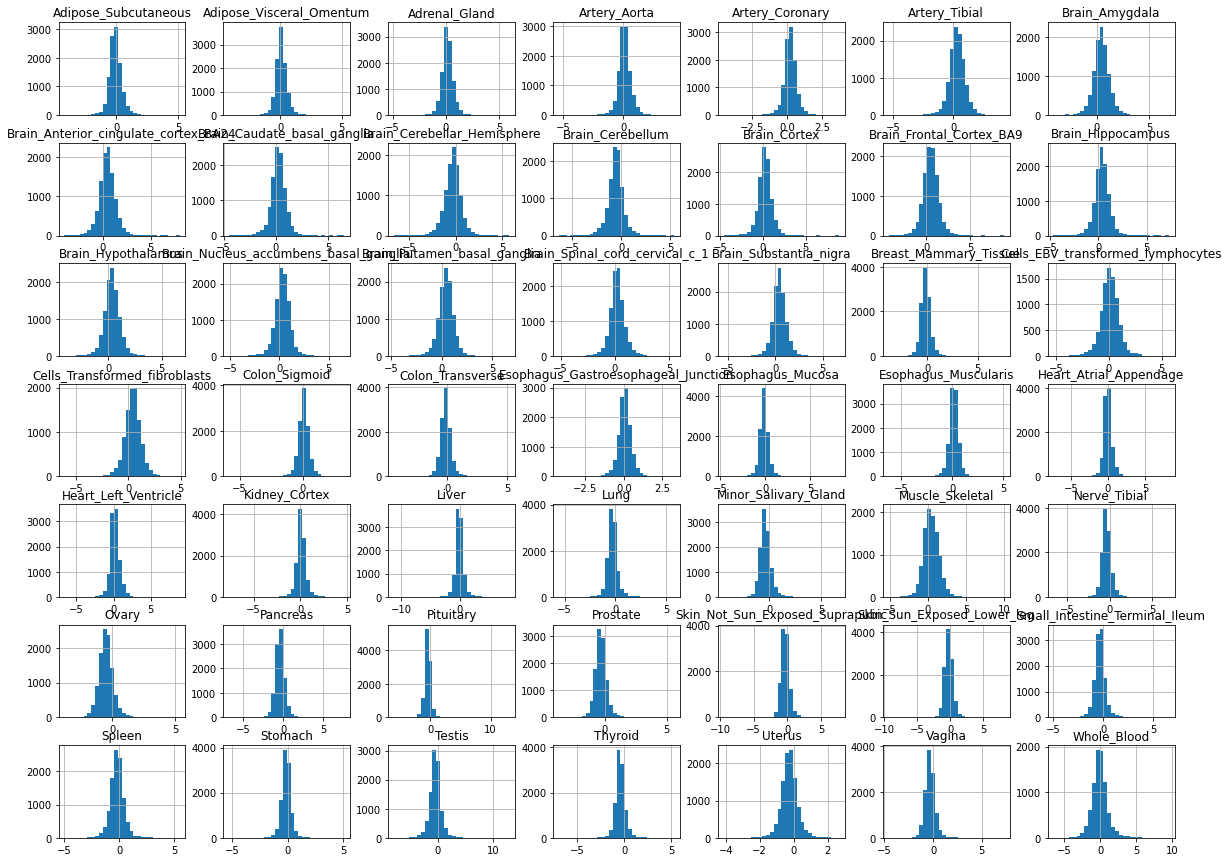

In [ ]:
phi_df = pd.DataFrame(get_all_halflife_values(data))
phi_df.hist(bins=30, figsize=(20, 15))

# Training Framework

In this section we're preparing the framework for fitting, evaluating and visualizing the models and their results.

## Visualization

We're defining some functions to extract useful metrics from regression results.
The function `get_stats` extracts some statistics from a given list of $R^2$ values:

In [ ]:
def get_stats(cv_r_squared_list):
  # cv_r_squared_list contains a list for each fold
  # each of these lists contains a list of r_squared values for each tissue
  r_squared_arr = np.array(cv_r_squared_list)
  r_squared_mean = np.mean(r_squared_arr, axis=0)
  r_squared_std = np.std(r_squared_arr, axis=0)
  stats = pd.DataFrame({"tissue": tissue_names, "r_squared_mean": r_squared_mean, "r_squared_std": r_squared_std})
  return stats

The function `plot_r_squared` creates a barplot of $R^2$ values per tissue and also includes the standard deviation per tissue as an errorbar:

In [ ]:
def plot_r_squared(stats):
  plot = ggplot(stats) + geom_col(aes(x="tissue", y="r_squared_mean")) + geom_errorbar(aes(x="tissue", ymin="r_squared_mean-r_squared_std", ymax="r_squared_mean+r_squared_std")) + theme(axis_text_x=element_text(rotation=90, hjust=0.5))
  print(plot)

The function `plot_r_squared_against` allows for comparison of different $R^2$ distributions, i.e. the $R^2$ value of one model in a specific tissue is plotted against the same value in another model:

In [ ]:
def plot_r_squared_against(r_squared_x, r_squared_y, modelname_x, modelname_y):
  r1 = pd.DataFrame({"r_squared": r_squared_x, "tissue": tissue_names})
  r2 = pd.DataFrame({"r_squared": r_squared_y, "tissue": tissue_names})
  plot_data = pd.merge(r1, r2, on="tissue")
  plot = ggplot(plot_data) + geom_point(aes(x="r_squared_x", y="r_squared_y")) + geom_abline(slope=1, intercept=0) + xlab(modelname_x) + ylab(modelname_y)
  print(plot)

Finally, `plot_params` creates a heatmap, visualizing the coefficient of each feature per tissue.

This way, one can easily compare both, each features importance across different tissue types, as well as the differences in importance of several features in a single tissue type:

In [ ]:
def plot_params(final_fit_results, feat_names):
  coeff = list(map(lambda result: result.params, final_fit_results))
  plot_data = pd.DataFrame(coeff)
  plot_data.columns = feat_names
  plot_data.index = tissue_names
  plot_data = plot_data.reset_index()
  plot_data = plot_data.rename_axis(None, axis=1)
  plot_data.rename(columns={"feature": "tissue"}, inplace=True)
  plot_data = plot_data.melt(id_vars="tissue")
  plot_data.rename(columns={"variable": "feature", "value": "coeff"}, inplace=True)
  plot = ggplot(plot_data, aes("feature", "tissue", fill="coeff")) + geom_tile() + theme(figure_size=(14, 8), axis_text_x=element_text(rotation=90, hjust=0.5)) # + scale_fill_gradientn(colors=["red", "black", "green"])
  print(plot)

We also supply a method to separate by feature category as different categories of features have values of different magnitudes:

In [ ]:
def plot_params_by_category(final_fit_results, feature_names):
  coeff = list(map(lambda result: result.params, final_fit_results))
  plot_data = pd.DataFrame(coeff)
  plot_data.columns = feat_names
  plot_data.index = tissue_names
  plot_data = plot_data.reset_index()
  plot_data = plot_data.rename_axis(None, axis=1)
  plot_data.rename(columns={"feature": "tissue"}, inplace=True)
  plot_data = plot_data.melt(id_vars="tissue")
  plot_data.rename(columns={"variable": "feature", "value": "coeff"}, inplace=True)
  plot_data = pd.merge(plot_data, features, on="feature")
  for feature_category in pd.unique(plot_data["category"]):
    plot = ggplot(plot_data.loc[plot_data["category"] == feature_category], aes("feature", "tissue", fill="coeff")) + geom_tile() + theme(figure_size=(10, 8), axis_text_x=element_text(rotation=90, hjust=0.5)) + xlab(feature_category) # + scale_fill_gradientn(colors=["red", "black", "green"])
    print(plot)

And another method using the seaborn library to cluster the rows and columns in the heatmap:

In [ ]:
def cluster_plot_params(final_fit_results, feature_names):
  coeff = list(map(lambda result: result.params, final_fit_results))
  plot_data = pd.DataFrame(coeff)
  plot_data.columns = feature_names
  plot_data.index = tissue_names
  plot_data = plot_data.rename_axis(None, axis=1)
  sns.clustermap(plot_data, xticklabels=True, yticklabels=True, figsize=(24, 16))

Again, we offer a version that plots separate heatmaps per feature category:

In [ ]:
def cluster_plot_params_by_category(final_fit_results, feature_names):
  coeff = list(map(lambda result: result.params, final_fit_results))
  plot_data = pd.DataFrame(coeff)
  plot_data.columns = feature_names
  plot_data.index = tissue_names
  plot_data = plot_data.rename_axis(None, axis=1)
  for feat_cat in ["codon_freq", "rbp_score", "length", "gc_content"]:
    if get_feat_names([feat_cat]).isin(plot_data.columns).any():
      plot_data_cat = plot_data[get_feat_names([feat_cat])]
      sns.clustermap(plot_data_cat, xticklabels=True, yticklabels=True, figsize=(24, 16))
      plt.show()

## Evaluation

This section contains all the functions used to fit and evaluate different models.

The `eval_model` function fits a single model on training data and returns the regression result, as well as the $R^2$ value calculated on a separately supplied test set.
The fitting is done using ridge regression in order to not eliminate features but prevent overfitting, given a single $\alpha$ regularization parameter:

In [ ]:
def eval_model(phi_train, phi_test, feat_train, feat_test, alpha):
  # dropping NA's, although there shouldn't be any left at this point
  model = sm.OLS(phi_train, feat_train, missing='drop')
  # running this is required for obtaining normalized_cov_params
  fit1 = model.fit()
  # L1_wt=0 -> ridge, =1 -> lasso
  fit2 = model.fit_regularized(method="elastic_net", alpha=alpha, L1_wt=0)
  # we have to package this, as the regularized results class isn't fully implemented
  fit_result = sm.regression.linear_model.OLSResults(model, fit2.params, model.normalized_cov_params)
  
  phi_pred = fit_result.predict(feat_test)
  r_squared = r2_score(phi_test, phi_pred)

  return fit_result, r_squared

The `eval_models` function fits multiple models (one for each tissue type) on training data and returns the regression results as well as the $R^2$ values calculated on the separately supplied test data, given a single $\alpha$ regularization parameter:

In [ ]:
def eval_models(train_data, test_data, feature_names, alpha):
  fit_results = []
  r_squared_list = []
  
  for tissue_name in tissue_names:
    # Filter out NA's per tissue, to preserve as much of the data as possible
    train_data_clean = train_data.loc[get_feat_values(train_data, feature_names).notna().all(axis=1) & get_feat_values(train_data, [tissue_name]).notna().all(axis=1)]
    test_data_clean = test_data.loc[get_feat_values(test_data, feature_names).notna().all(axis=1) & get_feat_values(test_data, [tissue_name]).notna().all(axis=1)]

    phi_train = get_feat_values(train_data_clean, [tissue_name])
    phi_test = get_feat_values(test_data_clean, [tissue_name])
    feat_train = get_feat_values(train_data_clean, feature_names)
    feat_test = get_feat_values(test_data_clean, feature_names)

    fit_result, r_squared = eval_model(phi_train, phi_test, feat_train, feat_test, alpha)
    fit_results.append(fit_result)
    r_squared_list.append(r_squared)

  return fit_results, r_squared_list

The `run_cross_validation` function uses the previously defined CV across chromosomes to evaluate the model on the different folds of data using a single $\alpha$ regularization parameter:

In [ ]:
def run_cross_validation(feature_names, cv_folds, alpha):
  fit_results_best_fold = None
  r_squared_list_best_fold = []
  r_squared_mean_best_fold = -1
  cv_r_squared_list = []

  for i, (train_chroms, test_chroms) in enumerate(cv_folds):
    print("Evaluating fold", (i+1))
    train_data = data.loc[data["chromosome"].isin(train_chroms)]
    test_data = data.loc[data["chromosome"].isin(test_chroms)]
    fit_results, r_squared_list = eval_models(train_data, test_data, feature_names, alpha)
    cv_r_squared_list.append(r_squared_list)
    mean_r_squared = np.mean(r_squared_list)
    if mean_r_squared > r_squared_mean_best_fold or fit_results_best_fold is None:
      fit_results_best_fold = fit_results
      r_squared_mean_best_fold = mean_r_squared
      r_squared_list_best_fold = r_squared_list
    #print("Mean R^2 across tissues in fold", (i+1), "is", np.mean(r_squared_list))
    #print("Max R^2 across tissues in fold", (i+1), "is", np.max(r_squared_list))

  print("Mean R^2 across tissues across folds is", np.mean(cv_r_squared_list))
  print("Max R^2 across tissues across folds is", np.max(cv_r_squared_list))

  return fit_results_best_fold, cv_r_squared_list, r_squared_list_best_fold

Finally, `evaluate_alphas` performs cross validation for every supplied alpha hyperparameter, visualizes the results and returns the best models (one model per tissue type, all for one common $\alpha$ parameter):

In [ ]:
def evaluate_alphas(feature_names, cv_folds, alphas):
  final_fit_results = None
  final_r_squared_list = None
  best_r_squared = -1
  best_alpha = None
  for alpha in alphas:
    print("# Evaluating model with alpha =", alpha)
    best_fit_results, cv_r_squared_list, r_squared_list_best_fold = run_cross_validation(feature_names, cv_folds, alpha)
    stats = get_stats(cv_r_squared_list)
    plot_r_squared(stats)
    mean_r_squared = np.mean(r_squared_list_best_fold)
    if mean_r_squared > best_r_squared:
      final_fit_results = best_fit_results
      best_r_squared = mean_r_squared
      final_r_squared_list = r_squared_list_best_fold
      best_alpha = alpha
    print()
  print("# Best model: alpha =", best_alpha, "R^2 =", best_r_squared)
  return final_fit_results, final_r_squared_list

# Models

Finally, we can define, fit and evaluate the models.

We're starting with a baseline model which only considers codon frequencies as features.

The second model considers solely RBP binding scores as features.

Then, we're combining these two feature categories and fit on codon frequencies as well as RBP binding scores.

Finally, we're additionally supplying the features CDS, 5'UTR and 3'UTR lengths and GC content.

The possible regularization parameters are equal across models:

In [ ]:
alphas = [0, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]

## Model 1: Codon Frequencies

The first model works solely with codon frequencies as features.
This model serves as a baseline for further results.

Here, we're printing the relevant features:

In [ ]:
feat_names = get_feat_names(["codon_freq"])
get_feat_values(data, feat_names)

AAA       AAC       AAG       AAT       ACA       ACC       ACG  \
0      0.005556  0.022222  0.055556  0.011111  0.022222  0.038889  0.005556   
1      0.036101  0.025271  0.014440  0.021661  0.010830  0.003610  0.003610   
2      0.004728  0.002364  0.044917  0.004728  0.007092  0.014184  0.002364   
3      0.023965  0.019608  0.071895  0.015251  0.013072  0.010893  0.006536   
4      0.003906  0.015625  0.050781  0.003906  0.011719  0.031250  0.013672   
...         ...       ...       ...       ...       ...       ...       ...   
11358  0.034794  0.011598  0.025773  0.021907  0.021907  0.024485  0.005155   
11359  0.019417  0.009709  0.087379  0.009709  0.009709  0.058252  0.000000   
11360  0.011142  0.022284  0.025070  0.016713  0.025070  0.013928  0.000000   
11361  0.020661  0.033058  0.033058  0.000000  0.016529  0.033058  0.004132   
11362  0.032086  0.018717  0.010695  0.018717  0.018717  0.024064  0.000000   

            ACT       AGA       AGC  ...       TCG       TCT  TGA       TGC  \
0      0.011111  0.000000  0.011111  ...  0.005556  0.005556  0.0  0.000000   
1      0.018051  0.007220  0.018051  ...  0.000000  0.010830  0.0  0.018051   
2      0.002364  0.002364  0.018913  ...  0.007092  0.007092  0.0  0.014184   
3      0.008715  0.004357  0.017429  ...  0.002179  0.013072  0.0  0.006536   
4      0.005859  0.000000  0.035156  ...  0.007812  0.001953  0.0  0.013672   
...         ...       ...       ...  ...       ...       ...  ...       ...   
11358  0.021907  0.012887  0.033505  ...  0.003866  0.034794  0.0  0.009021   
11359  0.000000  0.019417  0.000000  ...  0.000000  0.009709  0.0  0.000000   
11360  0.019499  0.022284  0.008357  ...  0.002786  0.033426  0.0  0.005571   
11361  0.004132  0.012397  0.033058  ...  0.004132  0.012397  0.0  0.016529   
11362  0.029412  0.013369  0.021390  ...  0.005348  0.016043  0.0  0.002674   

            TGG       TGT       TTA       TTC       TTG       TTT  
0      0.022222  0.011111  0.005556  0.022222  0.011111  0.016667  
1      0.014440  0.014440  0.014440  0.025271  0.007220  0.025271  
2      0.004728  0.011820  0.002364  0.021277  0.004728  0.002364  
3      0.008715  0.004357  0.006536  0.013072  0.002179  0.028322  
4      0.011719  0.000000  0.000000  0.039062  0.011719  0.011719  
...         ...       ...       ...       ...       ...       ...  
11358  0.003866  0.012887  0.006443  0.009021  0.007732  0.007732  
11359  0.000000  0.000000  0.009709  0.019417  0.009709  0.000000  
11360  0.011142  0.027855  0.011142  0.005571  0.011142  0.008357  
11361  0.016529  0.004132  0.008264  0.033058  0.004132  0.004132  
11362  0.008021  0.002674  0.010695  0.013369  0.018717  0.029412  

[11363 rows x 64 columns]

### Fitting

We fit this first model using the different regularization hyperparameters:

# Evaluating model with alpha = 0
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is -1.561727867448988e+22
Max R^2 across tissues across folds is 0.10861701236441845


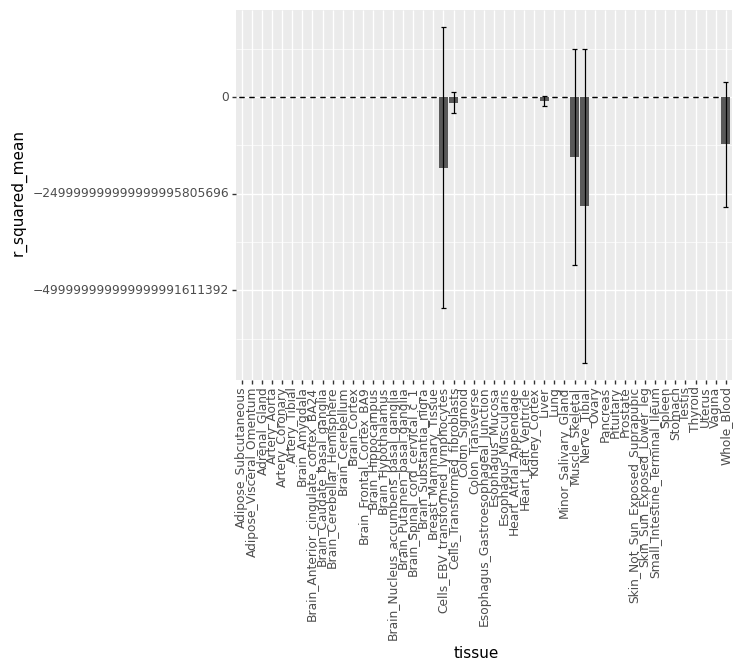

<ggplot: (8783989814253)>

# Evaluating model with alpha = 1e-05
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.030476334672558773
Max R^2 across tissues across folds is 0.11001530817907368


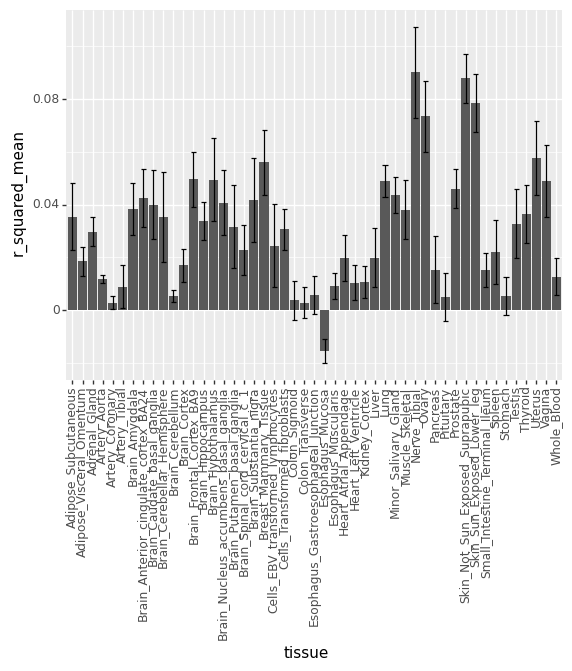

<ggplot: (8783987979269)>

# Evaluating model with alpha = 5e-05
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.032555143177677506
Max R^2 across tissues across folds is 0.11055516182505065


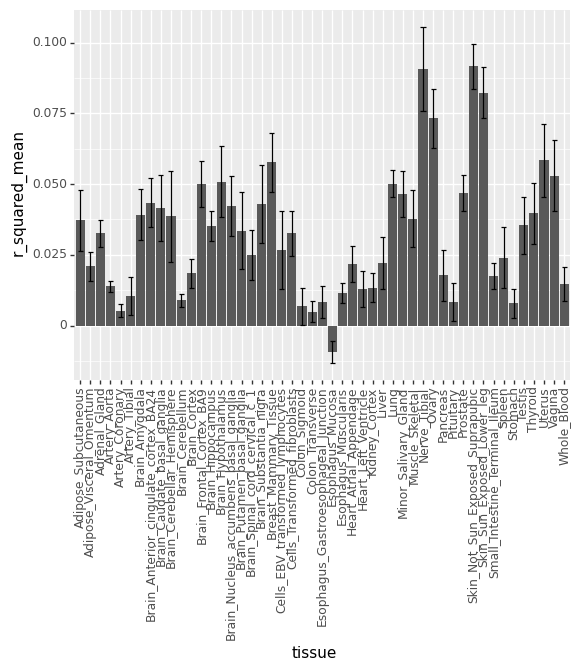

<ggplot: (8783987265605)>

# Evaluating model with alpha = 0.0001
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.032212538842092804
Max R^2 across tissues across folds is 0.10900552585314982


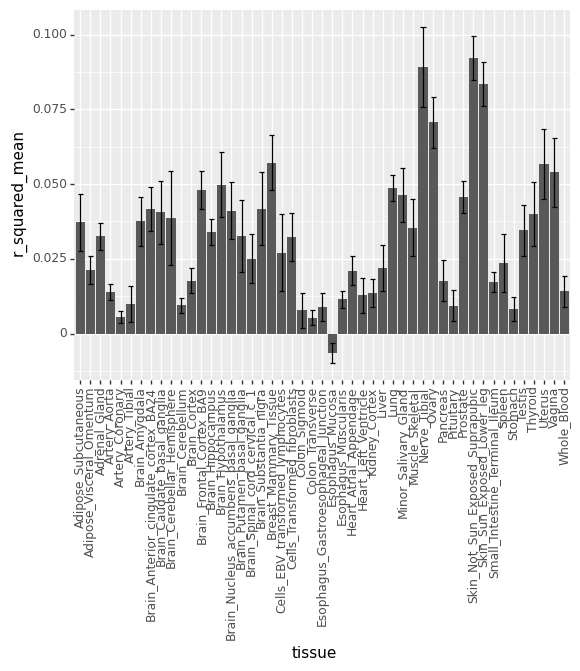

<ggplot: (8783982961757)>

# Evaluating model with alpha = 0.0005
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.02609590455306366
Max R^2 across tissues across folds is 0.09610078510603404


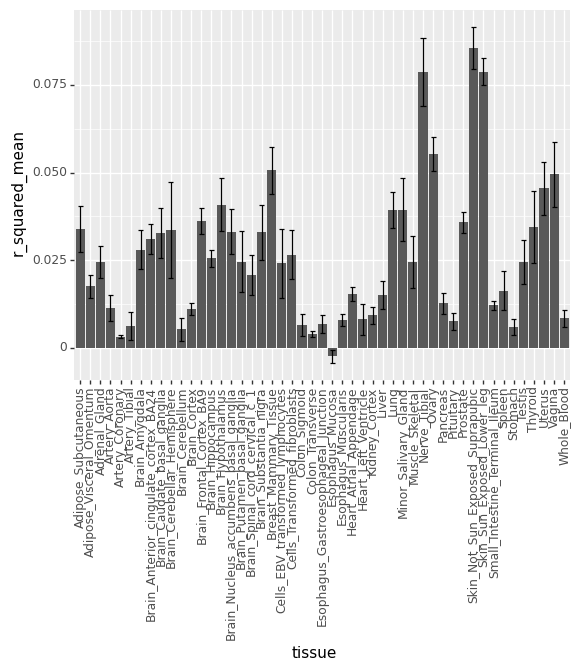

<ggplot: (8783982901601)>

# Evaluating model with alpha = 0.001
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.021389049032645272
Max R^2 across tissues across folds is 0.08339114219294252


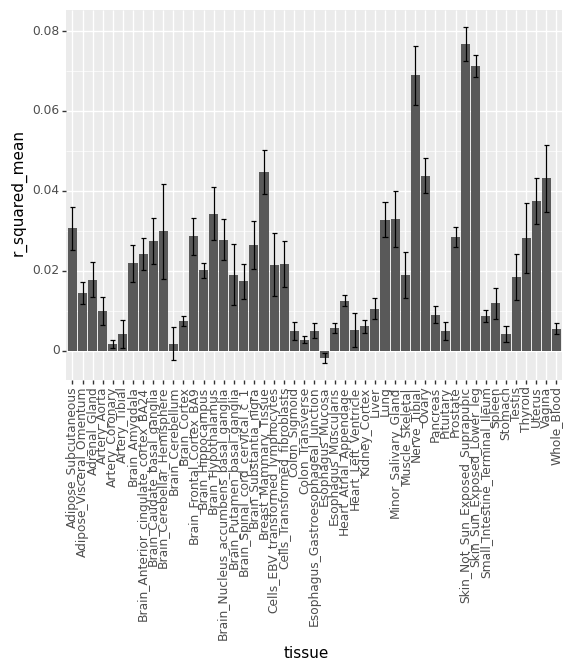

<ggplot: (8783982957705)>

# Evaluating model with alpha = 0.005
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.0002474475929599401
Max R^2 across tissues across folds is 0.03930074670201311


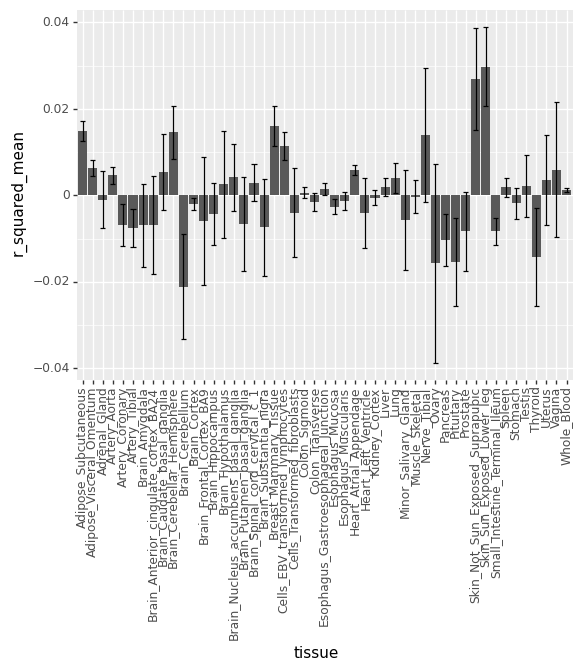

<ggplot: (8783982443077)>

# Evaluating model with alpha = 0.01
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is -0.019123717382495353
Max R^2 across tissues across folds is 0.023638057978159654


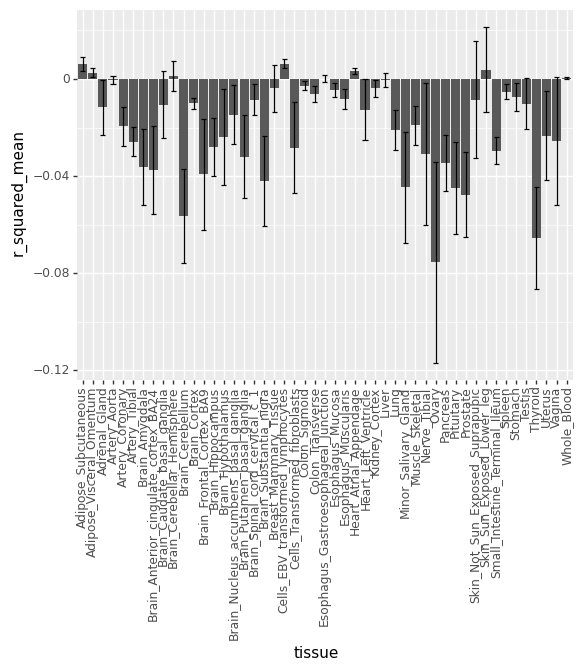

<ggplot: (8783982391889)>

# Evaluating model with alpha = 0.05
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is -0.1022969363997142
Max R^2 across tissues across folds is 0.0028150771356866278


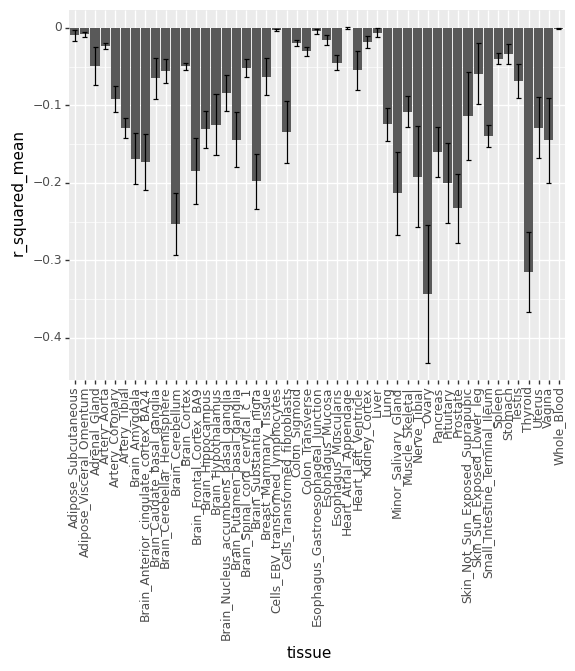

<ggplot: (8783982325917)>

# Best model: alpha = 5e-05 R^2 = 0.03762852269873032


In [ ]:
final_fit_results, final_r_squared_list_baseline = evaluate_alphas(feat_names, cv_folds, alphas)

The model without regularization performs very badly (negative mean $R^2$). This might be the case because the features are highly colinear.

The model using an $\alpha$ value of $5 * 10^{-5}$ performed best. It achieved a mean $R^2$ of $0.032555$ across tissues and folds, in the best-performing tissue type and fold even an $R^2$ of $0.110555$.

### Interpretation

We now plot the coefficients of the different features (extracted from the tissue-specific models in the best-performing fold) for every tissue type in order to find out more about the influence of certain features on mRNA half-life in different tissues:

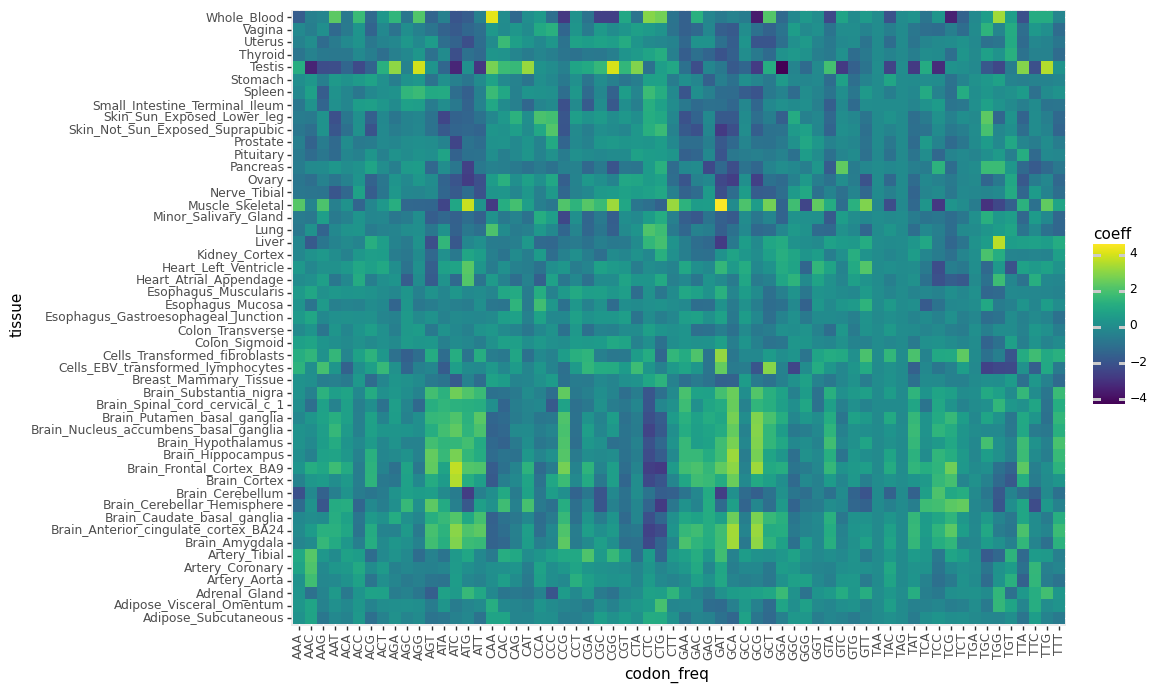

<ggplot: (8783982191689)>


In [ ]:
plot_params_by_category(final_fit_results, feat_names)

Every vertical line of either yellow or violet color highlights a consistent positive or negative influence of a certain feature across tissue types.

Most consistent contributions are across the brain tissues.

Some interesting findings are that
- in tissues of the brain, the codon frequencies of _ATC, CCG, GCA_ and _GCG_ had a fairly consistent positive influence on half-life.
- The frequencies of _CAA, CTC_ and _CTG_ had a fairly consistent negative influence in brain tissue. They both code for _Leucine_.
- _TAA, TAG_ and _TGA_ seem to have no real influence in any tissue. They all code for the _stop codon_.

However, due to the colinearity of codon frequencies and the use of regularization, an interpretation of these results is problematic.

We plot another heatmap but cluster the rows and columns in order to identify common patterns more easily:

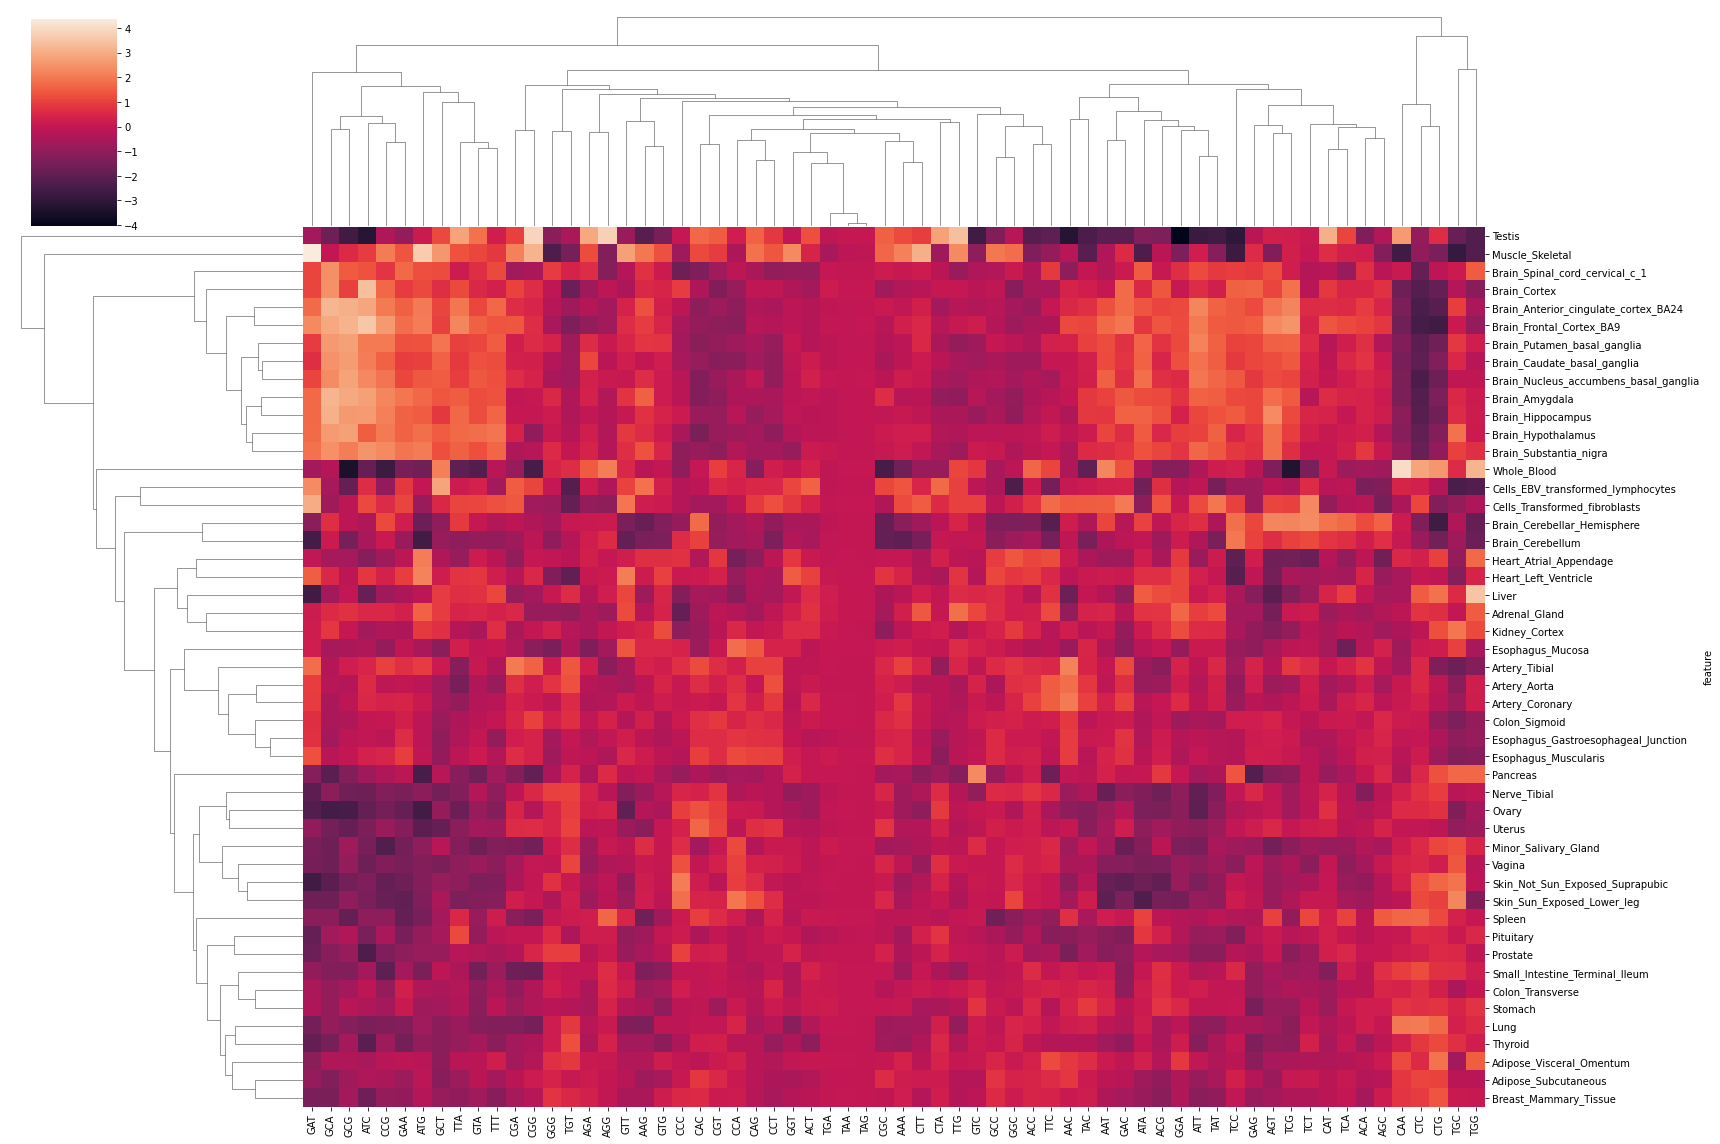

In [ ]:
cluster_plot_params_by_category(final_fit_results, feat_names)

## Model 2: RBPs

Next, we fit a model solely on RBP binding scores.
According to the mechanistic model we introduced at the start of this notebook, the learned parameters might correlate with a mixture of RBP concentration and influence of the RBP on mRNA half-life per tissue.

We again start by printing the relevant features:

In [ ]:
feat_names = get_feat_names(["rbp_score"])
get_feat_values(data, feat_names)

DND1     CPSF7     CPSF6     CPSF1     CSTF2    CSTF2T    ZC3H7B  \
0      0.466009  0.333622  0.437288  0.385020  0.381856  0.370452  0.055800   
1      0.625239  0.308348  0.366766  0.374922  0.399072  0.512726  0.335513   
2      0.521459  0.290612  0.447987  0.389843  0.095973  0.143399  0.218086   
3      0.709262  0.355740  0.485750  0.256741  0.244642  0.286161  0.191769   
4      0.662297  0.495711  0.456778  0.332413  0.482072  0.725908  0.260003   
...         ...       ...       ...       ...       ...       ...       ...   
11358  0.717967  0.401125  0.477838  0.478471  0.503547  0.741456  0.651293   
11359  0.133103  0.310725  0.417229  0.242206  0.082878  0.103396  0.062475   
11360  0.532119  0.455366  0.412922  0.208121  0.543813  0.696797  0.232554   
11361  0.478198  0.434359  0.433893  0.344058  0.177356  0.246209  0.144415   
11362  0.439113  0.512813  0.419897  0.352287  0.183963  0.234114  0.212331   

       FMR1iso1     RBM10     MOV10  ...      FXR1     NOP58     NOP56  \
0      0.295653  0.463529  0.306574  ...  0.089381  0.130150  0.134894   
1      0.429682  0.547450  0.476546  ...  0.222410  0.493327  0.239549   
2      0.197878  0.787376  0.395925  ...  0.035236  0.245104  0.125485   
3      0.450174  0.462189  0.425212  ...  0.096333  0.373058  0.126466   
4      0.300501  0.653451  0.445841  ...  0.147800  0.551409  0.295072   
...         ...       ...       ...  ...       ...       ...       ...   
11358  0.353836  0.550075  0.565889  ...  0.394178  0.556764  0.710953   
11359  0.362782  0.312279  0.284507  ...  0.055160  0.252344  0.271547   
11360  0.333743  0.595640  0.406836  ...  0.271856  0.779085  0.259617   
11361  0.301631  0.774920  0.367716  ...  0.134948  0.563118  0.123267   
11362  0.393941  0.804548  0.559419  ...  0.197310  0.435693  0.198299   

            FBL    LIN28A    LIN28B      UPF1       G35       G45      XPO5  
0      0.362862  0.185488  0.101833  0.075934  0.304871  0.262849  0.198160  
1      0.422607  0.300081  0.511566  0.212465  0.139636  0.303893  0.337837  
2      0.679963  0.214952  0.816133  0.078845  0.143686  0.205081  0.172913  
3      0.430117  0.402916  0.186499  0.149575  0.314400  0.504436  0.198861  
4      0.566890  0.398808  0.273079  0.215787  0.294323  0.403959  0.424652  
...         ...       ...       ...       ...       ...       ...       ...  
11358  0.380614  0.368731  0.737023  0.309320  0.275847  0.514541  0.471805  
11359  0.245479  0.271669  0.165971  0.033851  0.163344  0.419075  0.223508  
11360  0.393854  0.250726  0.507322  0.195718  0.238335  0.237361  0.378352  
11361  0.628366  0.436823  0.101388  0.334520  0.164246  0.214602  0.243445  
11362  0.439418  0.233155  0.176489  0.239051  0.226289  0.236632  0.348496  

[11363 rows x 59 columns]

### Fitting

This model is also evaluated on all different regularization hyperparameters:

# Evaluating model with alpha = 0
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.03215880068606058
Max R^2 across tissues across folds is 0.12005121280372377


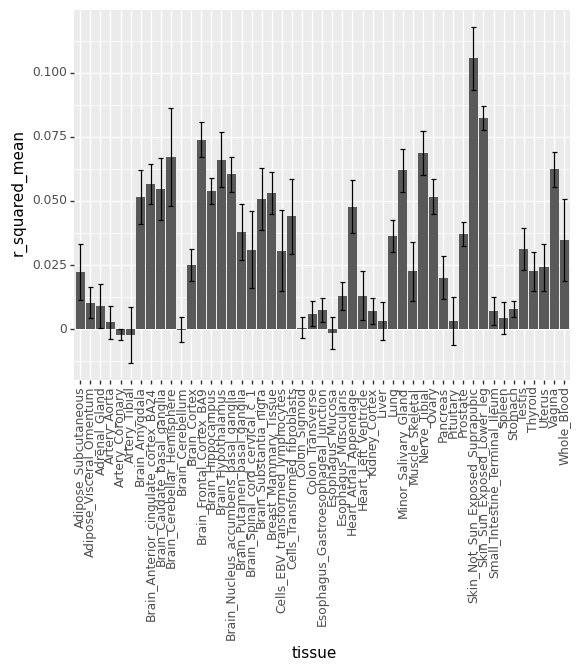

<ggplot: (8783981407857)>

# Evaluating model with alpha = 1e-05
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.032182931218934716
Max R^2 across tissues across folds is 0.12007933973244755


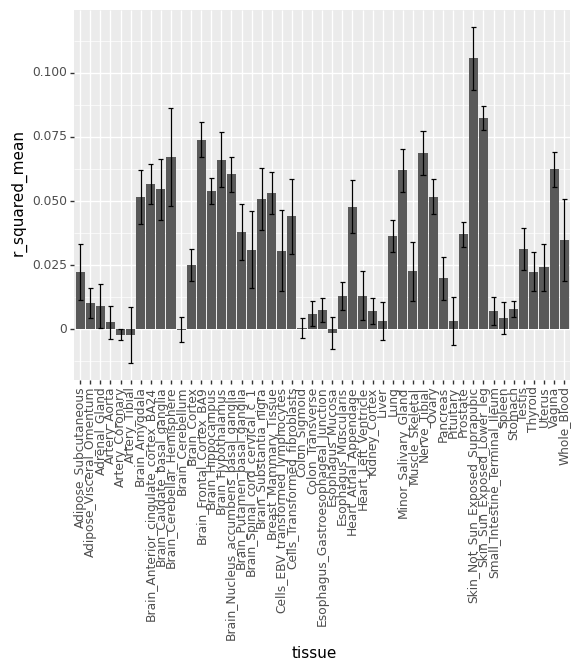

<ggplot: (8783981389445)>

# Evaluating model with alpha = 5e-05
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.03227654689157448
Max R^2 across tissues across folds is 0.12018938049260275


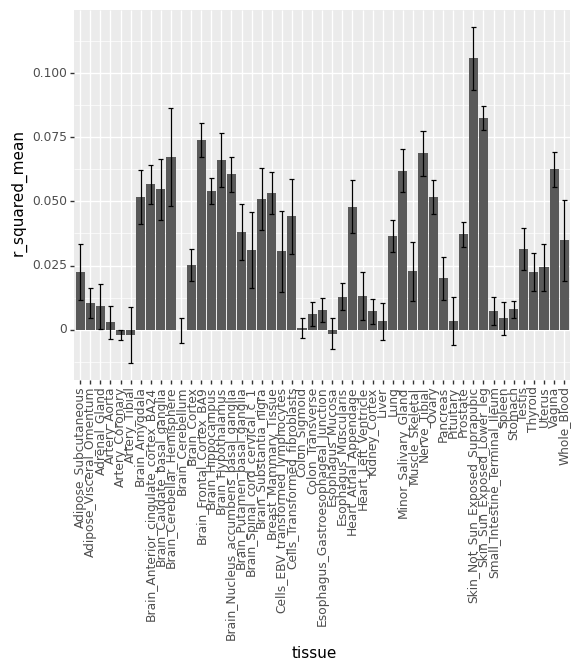

<ggplot: (8783982424033)>

# Evaluating model with alpha = 0.0001
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.03238740357410448
Max R^2 across tissues across folds is 0.12032158330840759


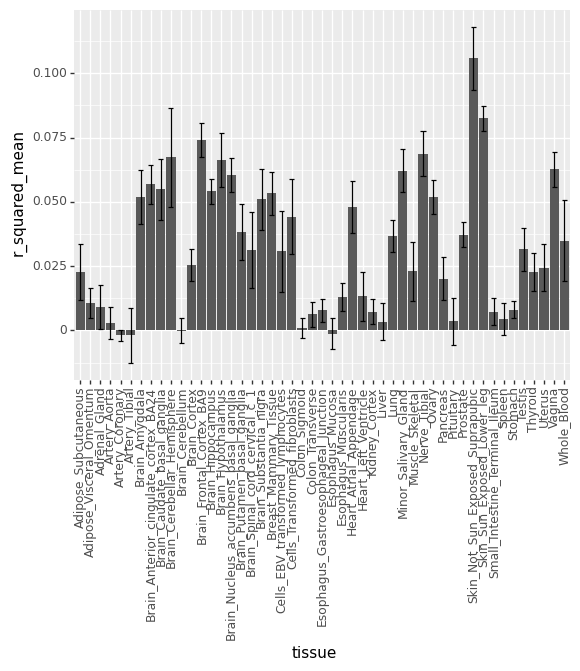

<ggplot: (8783982985665)>

# Evaluating model with alpha = 0.0005
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.03308288757296802
Max R^2 across tissues across folds is 0.12119982954003228


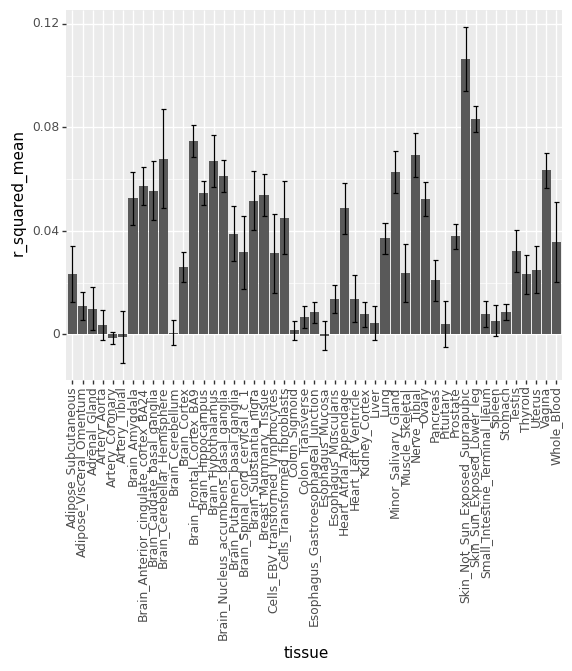

<ggplot: (8783987878713)>

# Evaluating model with alpha = 0.001
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.033637504993795184
Max R^2 across tissues across folds is 0.12196841309160211


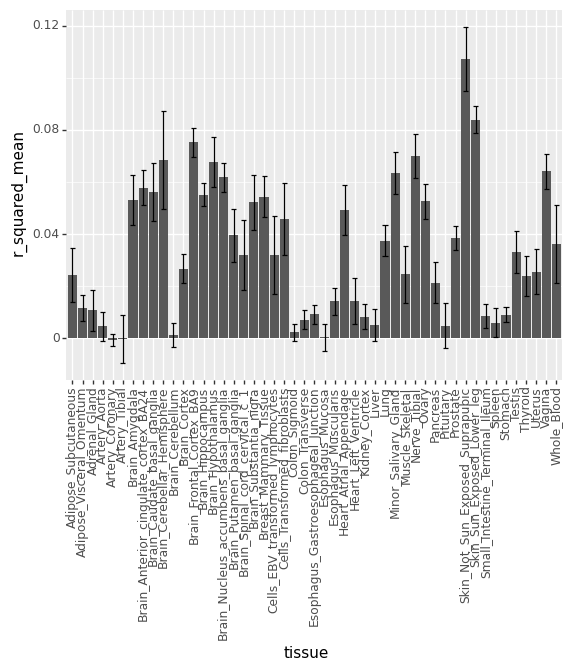

<ggplot: (8783987881145)>

# Evaluating model with alpha = 0.005
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.034458443433031054
Max R^2 across tissues across folds is 0.12348355584864201


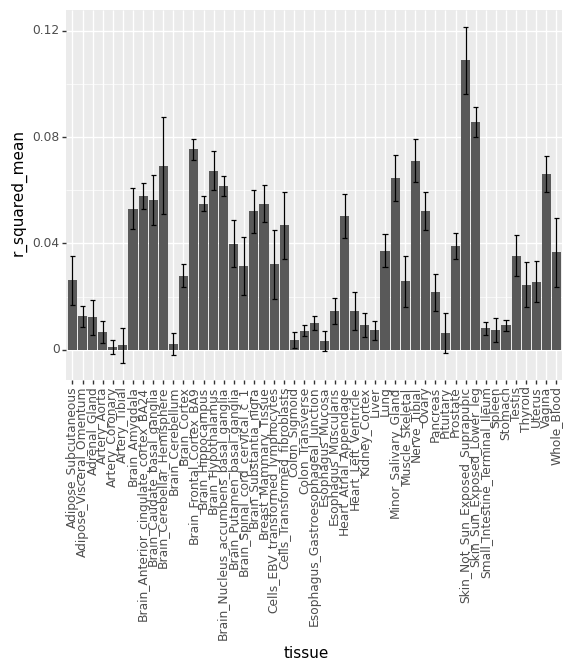

<ggplot: (8783982932569)>

# Evaluating model with alpha = 0.01
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.03383946072375033
Max R^2 across tissues across folds is 0.12279953999641169


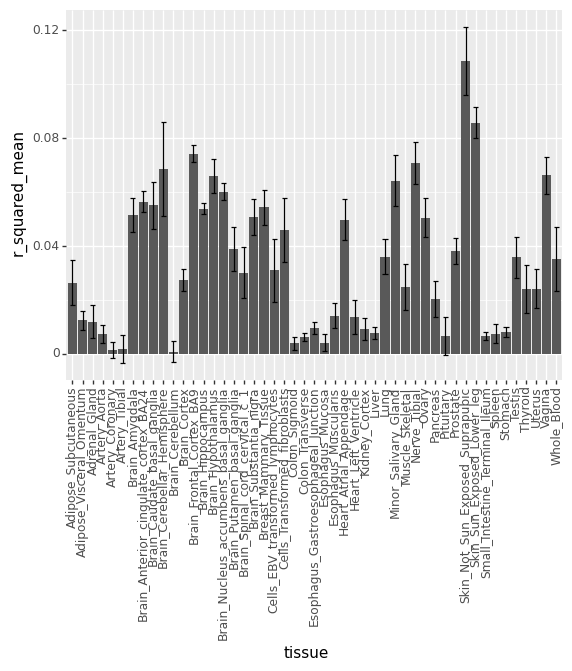

<ggplot: (8783982700717)>

# Evaluating model with alpha = 0.05
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.0292697918078234
Max R^2 across tissues across folds is 0.11549034607193931


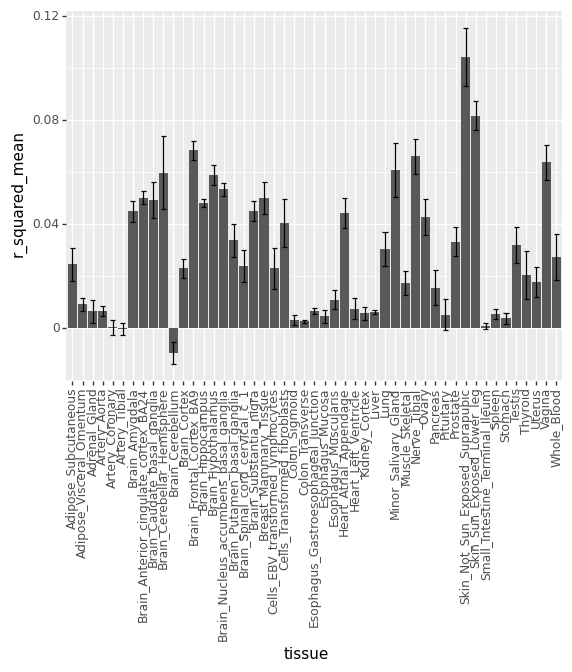

<ggplot: (8783987700773)>

# Best model: alpha = 0.005 R^2 = 0.03858159761019537


In [ ]:
final_fit_results, final_r_squared_list = evaluate_alphas(feat_names, cv_folds, alphas)

For this model, an $\alpha$ value of $0.005$ lead to the best results, i.e. an mean $R^2$ across tissues across folds of $0.034458$ and a maximal $R^2$ value of $0.123484$.

This is an improved result compared to the first model, meaning that more variation can be explained from RBP binding scores than from codon frequencies.

It's also interesting to note that this model performed fairly well even when applying no regularization. This might be the case because RBP binding scores are less correlated than codon frequencies.

We can compare this model's performance against the baseline model (using codon frequencies), by plotting their $R^2$ values per tissue type against each other:

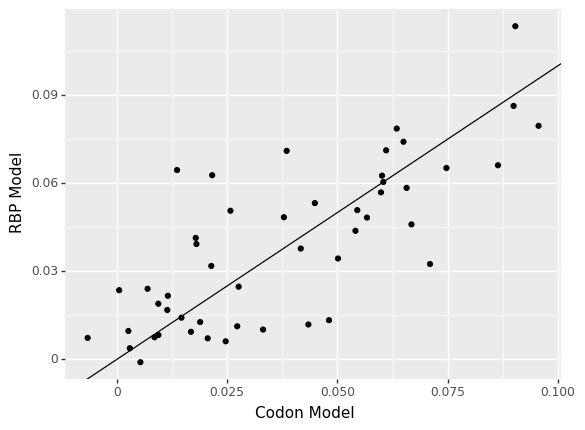

<ggplot: (8783981611177)>


In [ ]:
plot_r_squared_against(final_r_squared_list_baseline, final_r_squared_list, "Codon Model", "RBP Model")

### Interpretation

By examining the coefficients with the highest absolute value, and especially comparing their influence across tissues, we can try to predict the concentration and influence of the RBPs on mRNA half-life in different tissues:

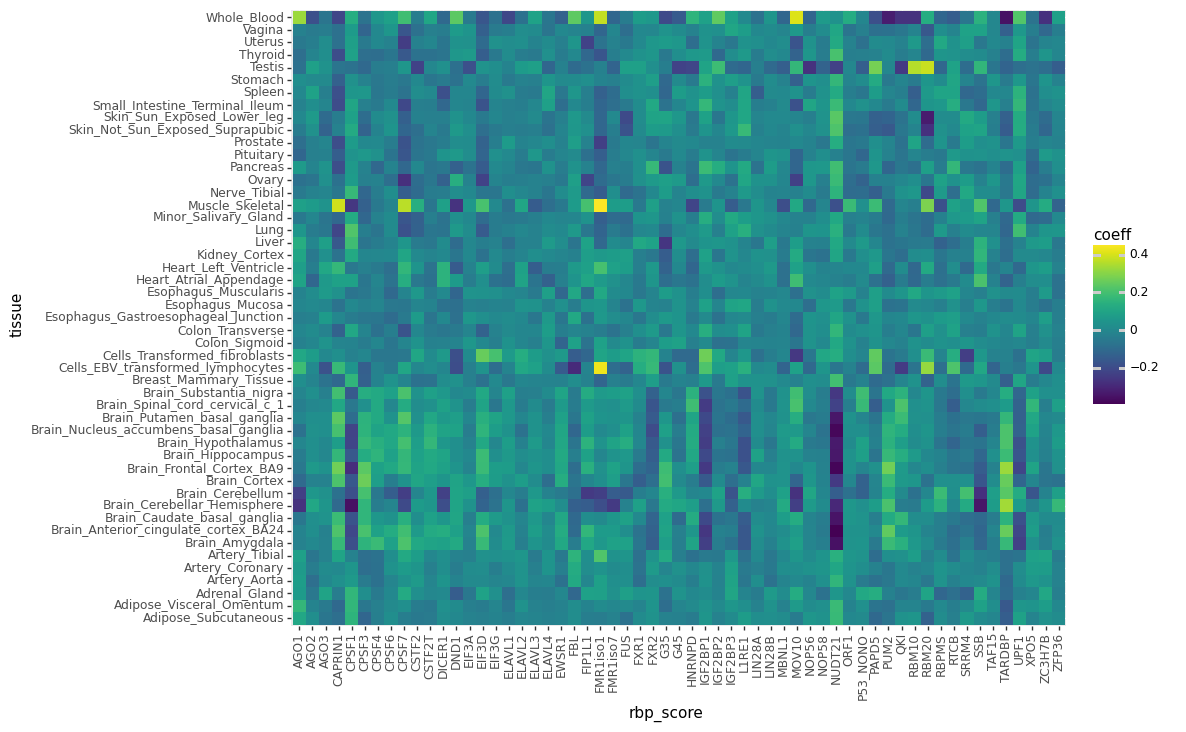

<ggplot: (8783982616637)>


In [ ]:
plot_params_by_category(final_fit_results, feat_names)

Again, most consistent contributions are across the brain tissues.

Some interesting findings are:

- _NUDT21_, _IGF2BP1_ and _CPSF1_ contributing consisistently and strongly in a negative way to half-life in brain tissues.
- _TARDBP_ contributing consistently and strongly in a positive way to half-life in brain tissues.

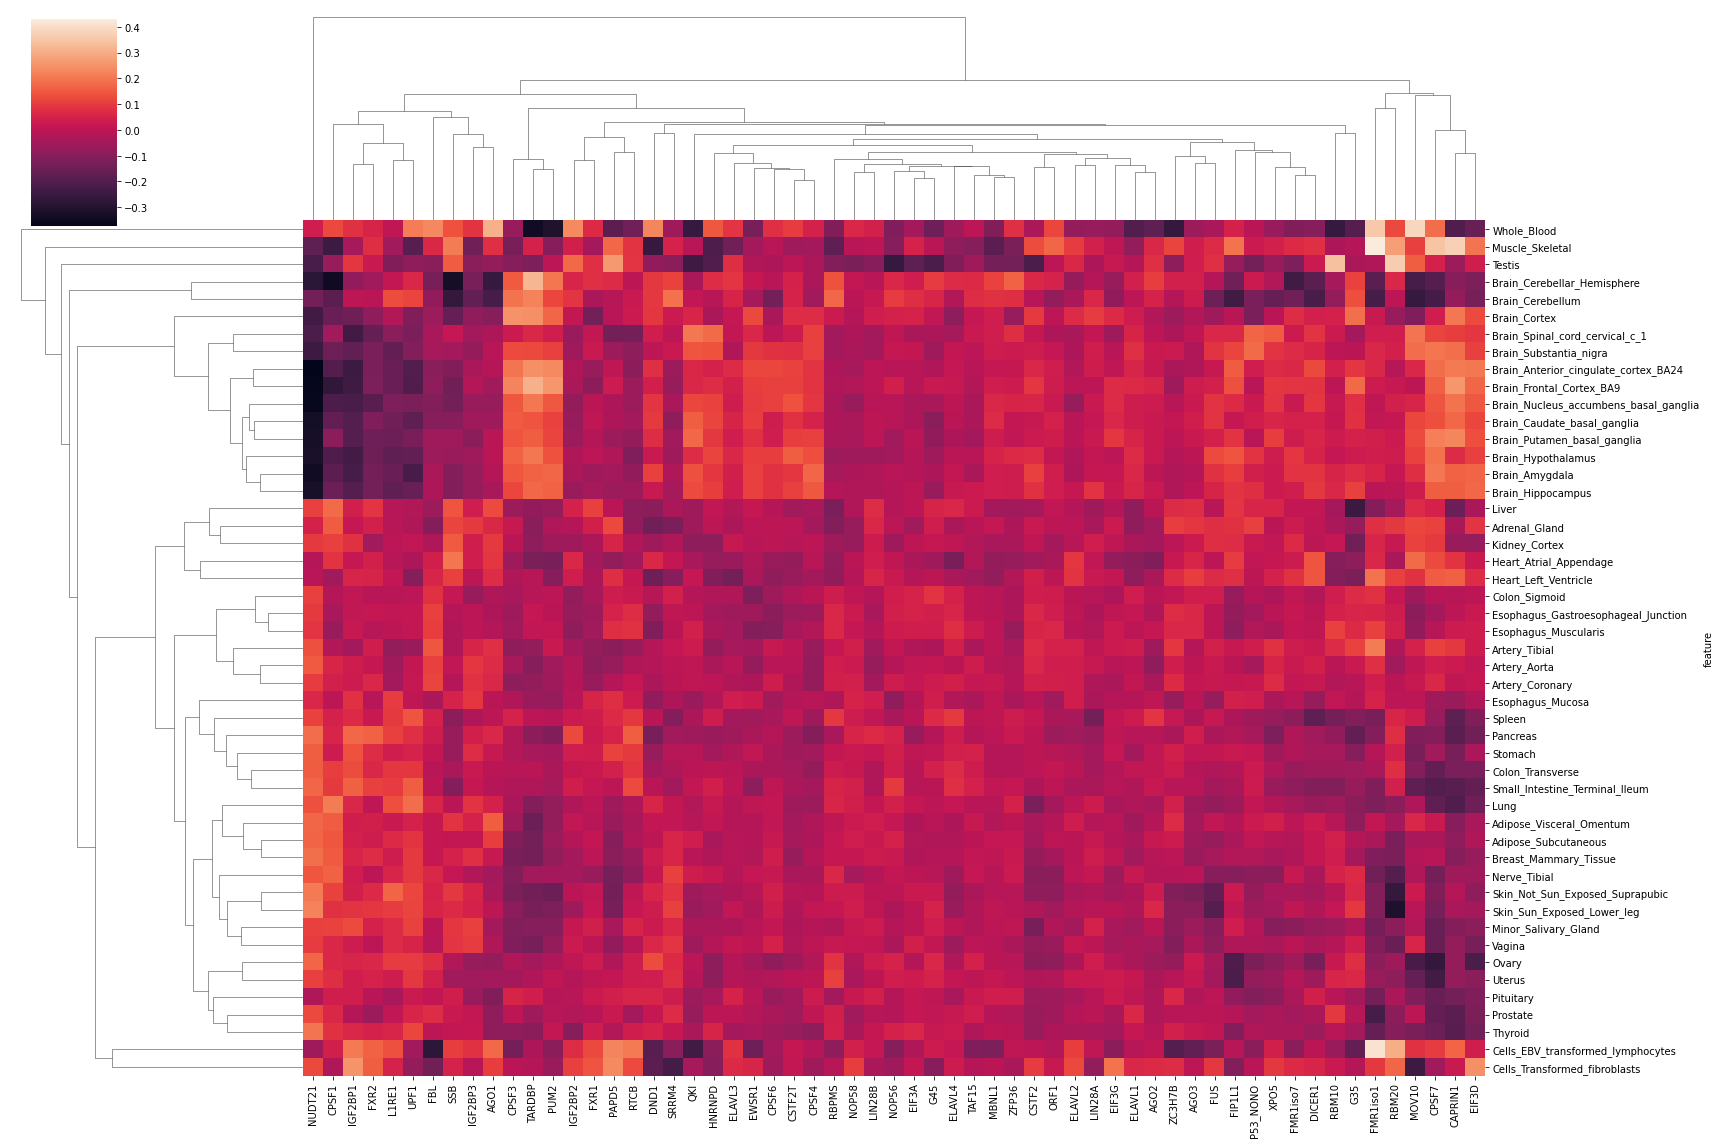

In [ ]:
cluster_plot_params_by_category(final_fit_results, feat_names)

Using this clustered heatmap also reveals that _RBM20_ has a strong negative contribution in skin tissue.

## Model 3: RBPs & Codon Frequencies

The third model now combines codon frequencies and RBP binding scores as features.

The combined features are:

In [ ]:
feat_names = get_feat_names(["codon_freq", "rbp_score"])
get_feat_values(data, feat_names)

AAA       AAC       AAG       AAT       ACA       ACC       ACG  \
0      0.005556  0.022222  0.055556  0.011111  0.022222  0.038889  0.005556   
1      0.036101  0.025271  0.014440  0.021661  0.010830  0.003610  0.003610   
2      0.004728  0.002364  0.044917  0.004728  0.007092  0.014184  0.002364   
3      0.023965  0.019608  0.071895  0.015251  0.013072  0.010893  0.006536   
4      0.003906  0.015625  0.050781  0.003906  0.011719  0.031250  0.013672   
...         ...       ...       ...       ...       ...       ...       ...   
11358  0.034794  0.011598  0.025773  0.021907  0.021907  0.024485  0.005155   
11359  0.019417  0.009709  0.087379  0.009709  0.009709  0.058252  0.000000   
11360  0.011142  0.022284  0.025070  0.016713  0.025070  0.013928  0.000000   
11361  0.020661  0.033058  0.033058  0.000000  0.016529  0.033058  0.004132   
11362  0.032086  0.018717  0.010695  0.018717  0.018717  0.024064  0.000000   

            ACT       AGA       AGC  ...      FXR1     NOP58     NOP56  \
0      0.011111  0.000000  0.011111  ...  0.089381  0.130150  0.134894   
1      0.018051  0.007220  0.018051  ...  0.222410  0.493327  0.239549   
2      0.002364  0.002364  0.018913  ...  0.035236  0.245104  0.125485   
3      0.008715  0.004357  0.017429  ...  0.096333  0.373058  0.126466   
4      0.005859  0.000000  0.035156  ...  0.147800  0.551409  0.295072   
...         ...       ...       ...  ...       ...       ...       ...   
11358  0.021907  0.012887  0.033505  ...  0.394178  0.556764  0.710953   
11359  0.000000  0.019417  0.000000  ...  0.055160  0.252344  0.271547   
11360  0.019499  0.022284  0.008357  ...  0.271856  0.779085  0.259617   
11361  0.004132  0.012397  0.033058  ...  0.134948  0.563118  0.123267   
11362  0.029412  0.013369  0.021390  ...  0.197310  0.435693  0.198299   

            FBL    LIN28A    LIN28B      UPF1       G35       G45      XPO5  
0      0.362862  0.185488  0.101833  0.075934  0.304871  0.262849  0.198160  
1      0.422607  0.300081  0.511566  0.212465  0.139636  0.303893  0.337837  
2      0.679963  0.214952  0.816133  0.078845  0.143686  0.205081  0.172913  
3      0.430117  0.402916  0.186499  0.149575  0.314400  0.504436  0.198861  
4      0.566890  0.398808  0.273079  0.215787  0.294323  0.403959  0.424652  
...         ...       ...       ...       ...       ...       ...       ...  
11358  0.380614  0.368731  0.737023  0.309320  0.275847  0.514541  0.471805  
11359  0.245479  0.271669  0.165971  0.033851  0.163344  0.419075  0.223508  
11360  0.393854  0.250726  0.507322  0.195718  0.238335  0.237361  0.378352  
11361  0.628366  0.436823  0.101388  0.334520  0.164246  0.214602  0.243445  
11362  0.439418  0.233155  0.176489  0.239051  0.226289  0.236632  0.348496  

[11363 rows x 123 columns]

### Fitting

# Evaluating model with alpha = 0
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is -9.426612219080428e+21
Max R^2 across tissues across folds is 0.13375848990367267


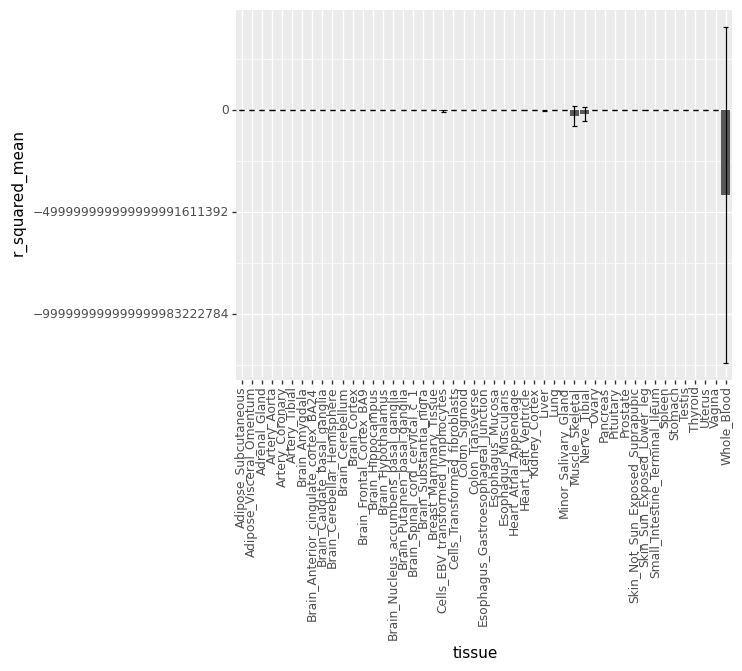

<ggplot: (8783981395077)>

# Evaluating model with alpha = 1e-05
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.04634713980119713
Max R^2 across tissues across folds is 0.13721053379676695


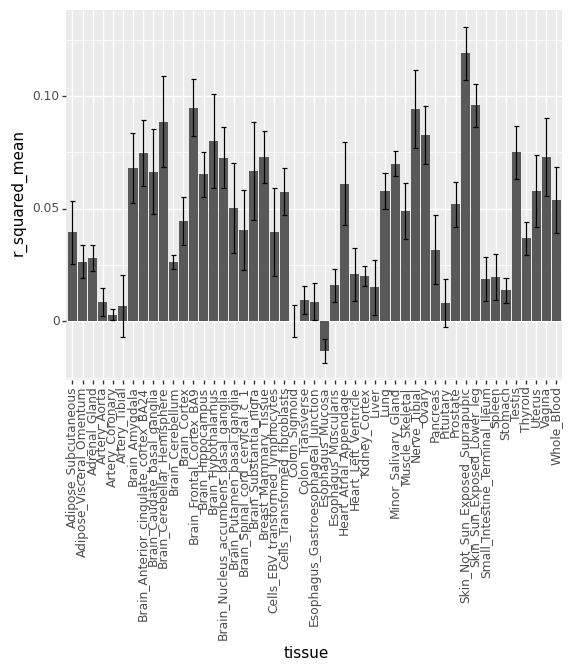

<ggplot: (8783981825745)>

# Evaluating model with alpha = 5e-05
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.048724801477319536
Max R^2 across tissues across folds is 0.14119417908551068


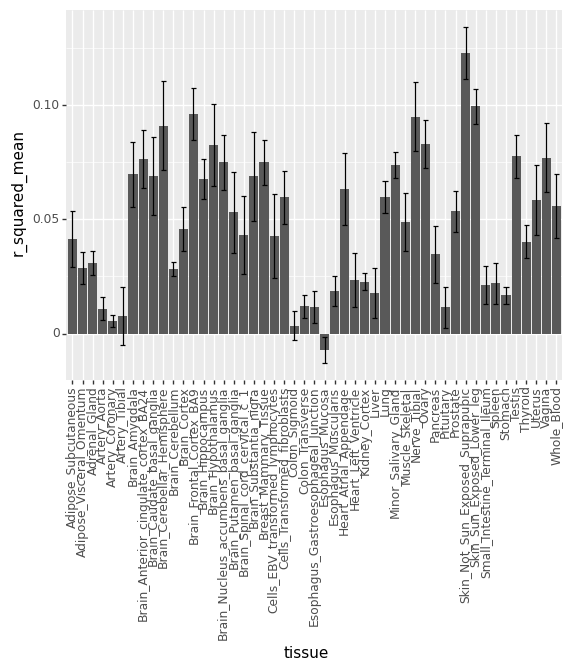

<ggplot: (8783981829097)>

# Evaluating model with alpha = 0.0001
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.04863755734146818
Max R^2 across tissues across folds is 0.14216222612636642


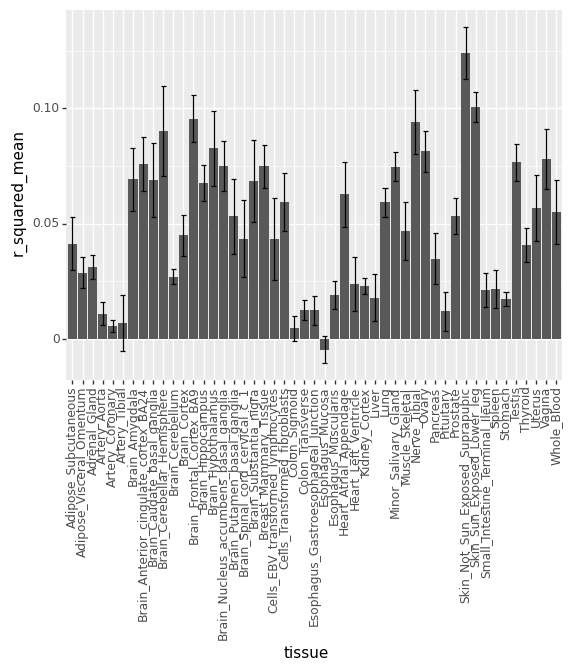

<ggplot: (8783981911145)>

# Evaluating model with alpha = 0.0005
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.04390487684722648
Max R^2 across tissues across folds is 0.13802592330433006


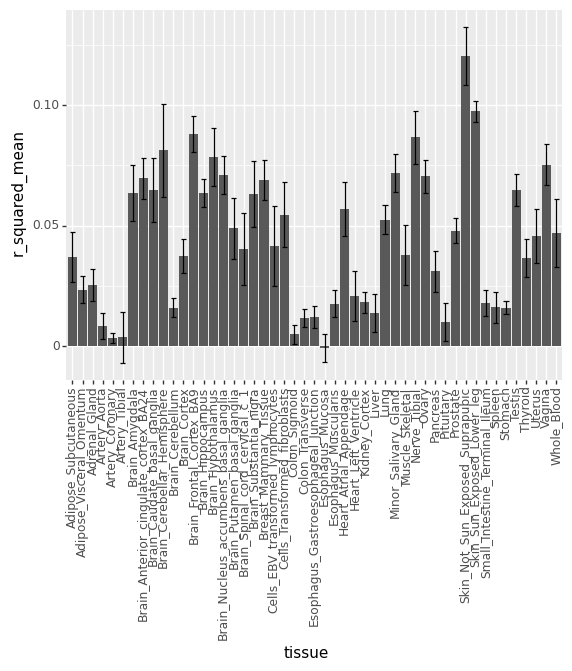

<ggplot: (8783981086273)>

# Evaluating model with alpha = 0.001
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.04121895091455343
Max R^2 across tissues across folds is 0.13437703963319536


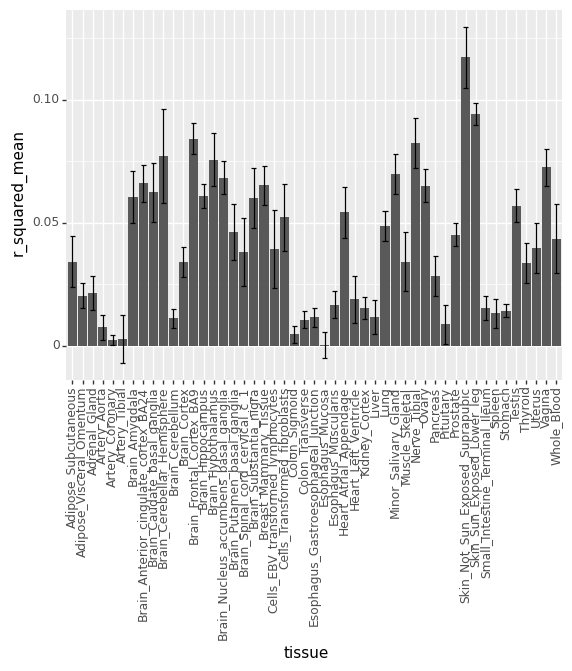

<ggplot: (8783981036013)>

# Evaluating model with alpha = 0.005
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.036950267301523905
Max R^2 across tissues across folds is 0.12791946998794657


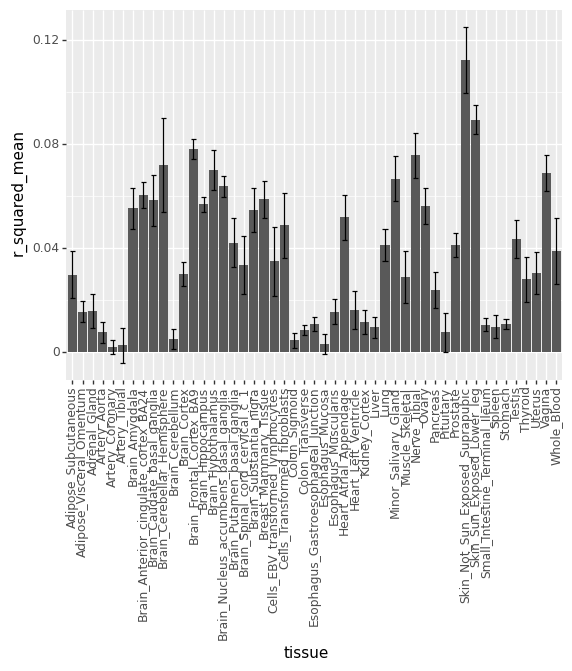

<ggplot: (8783981187093)>

# Evaluating model with alpha = 0.01
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.03530771196869919
Max R^2 across tissues across folds is 0.12551953419249728


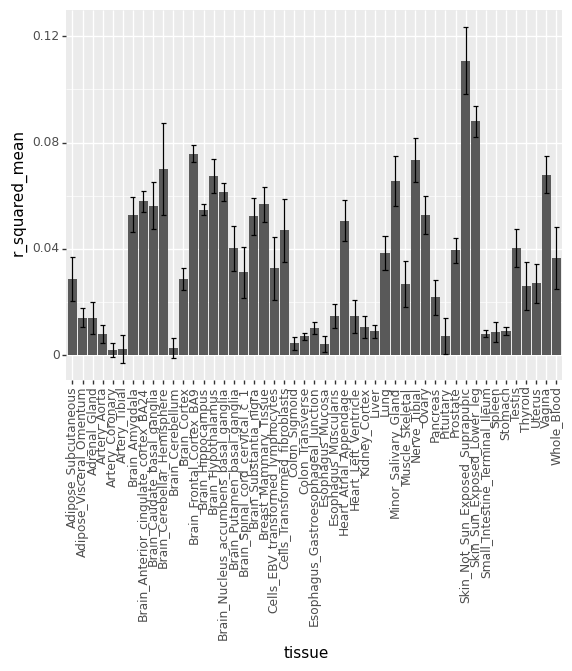

<ggplot: (8783981009577)>

# Evaluating model with alpha = 0.05
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.029714102553683217
Max R^2 across tissues across folds is 0.11649919530730901


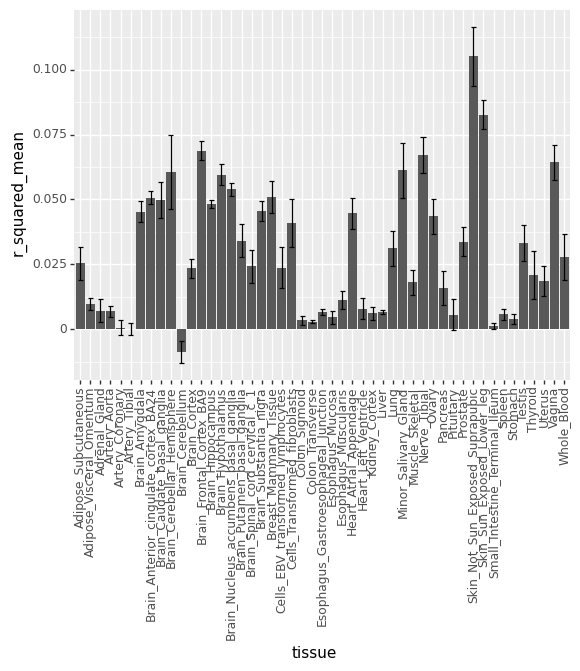

<ggplot: (8783988290901)>

# Best model: alpha = 5e-05 R^2 = 0.05532281092833057


In [ ]:
final_fit_results, final_r_squared_list = evaluate_alphas(feat_names, cv_folds, alphas)

For this combined feature set, an alpha value of $5 * 10^{-5}$ lead to the best results: A mean $R^2$ value across tissues across folds of $0.048725$ and a max $R^2$ value of $0.141194$.

This result further improves upon both previous models.

This model (which includes codon frequences again) also performed very badly without regularization, underlining the previously proposed assumption for this behavior.

Again, we compare this model's performance against the baseline model:

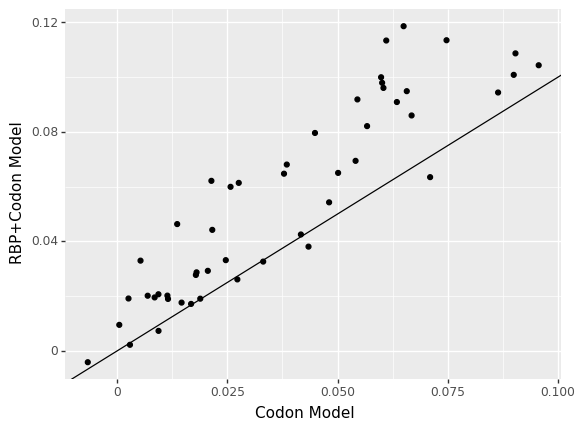

<ggplot: (8783982689301)>


In [ ]:
plot_r_squared_against(final_r_squared_list_baseline, final_r_squared_list, "Codon Model", "RBP+Codon Model")

### Interpretation

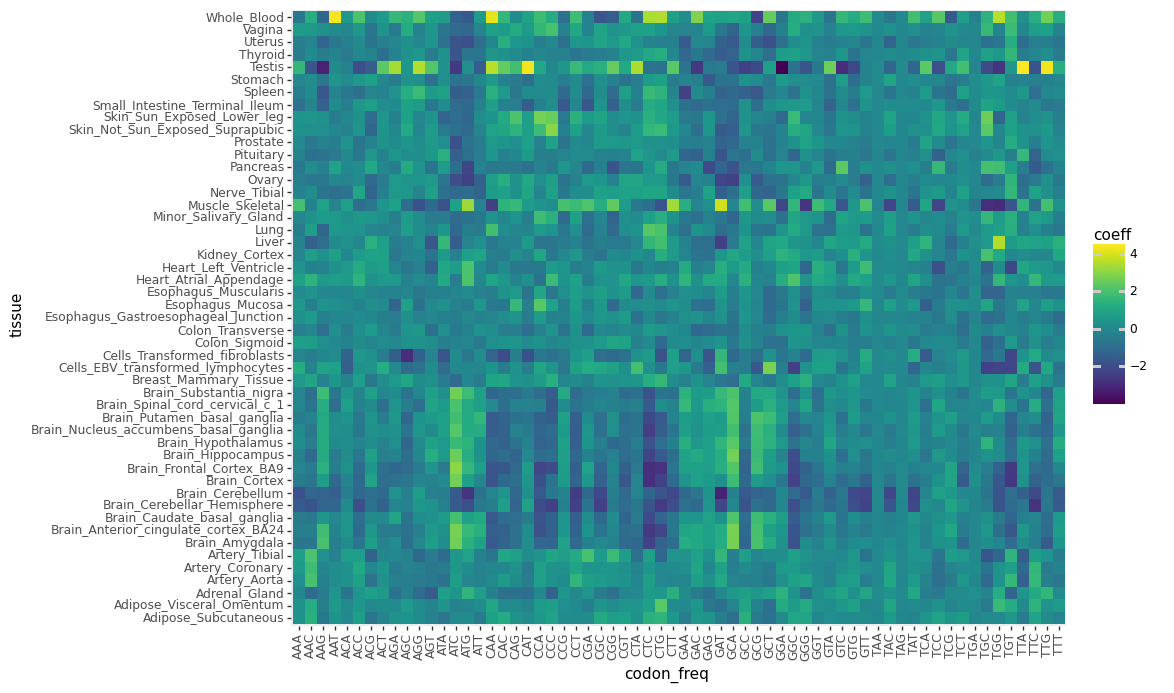

<ggplot: (8783981275689)>


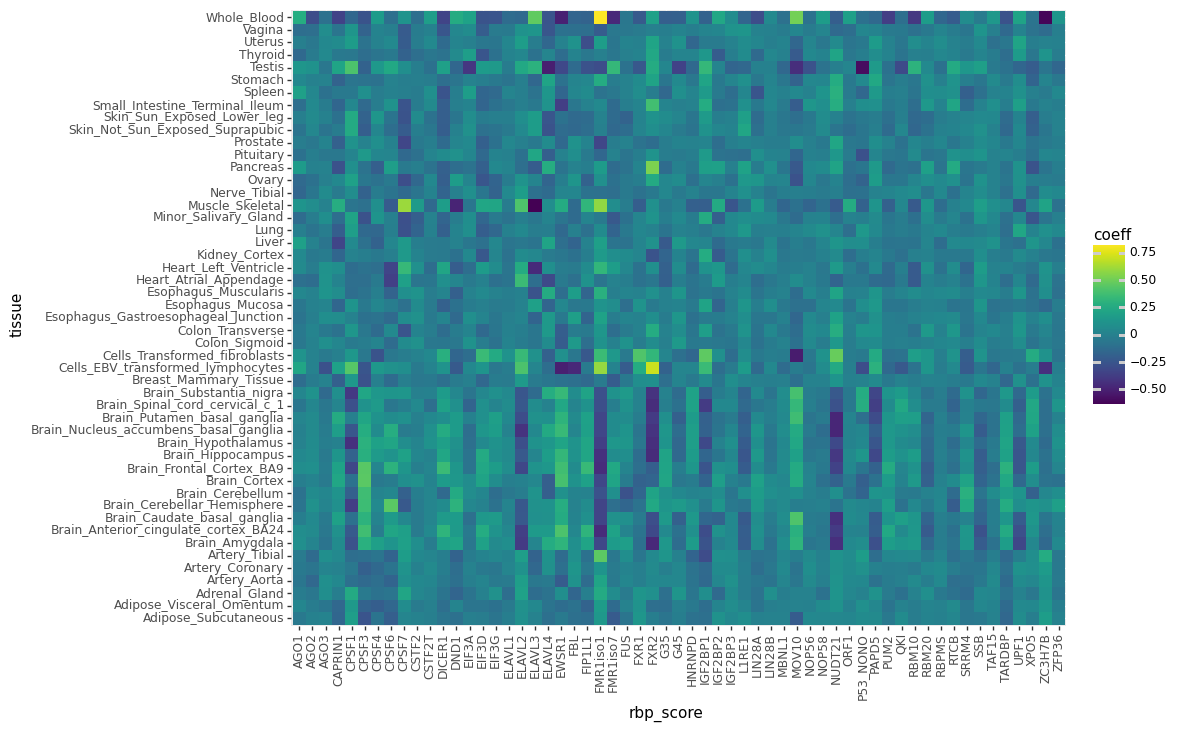

<ggplot: (8783981570293)>


In [ ]:
plot_params_by_category(final_fit_results, feat_names)

Some interesting findings in this model are:

- Fairly consistent positive influence of _ATC_ and _GCA_ in brain tissues.
- Fairly consistent negative influence of _CCA_ and _CCC_ (both coding for _Proline_), as well as _CTC_ and _CTG_ (both coding for _Leucine_) in brain tissues.
- _CPSF3, EWSR1_ and _MOV10_ contributing consistently positive in brain tissues.
- _CPSF1, ELAVL2, FMR1iso1, FXR2_ and _NUDT21_ contributing consistently and strongly in a negative way to half-life in brain tissues.

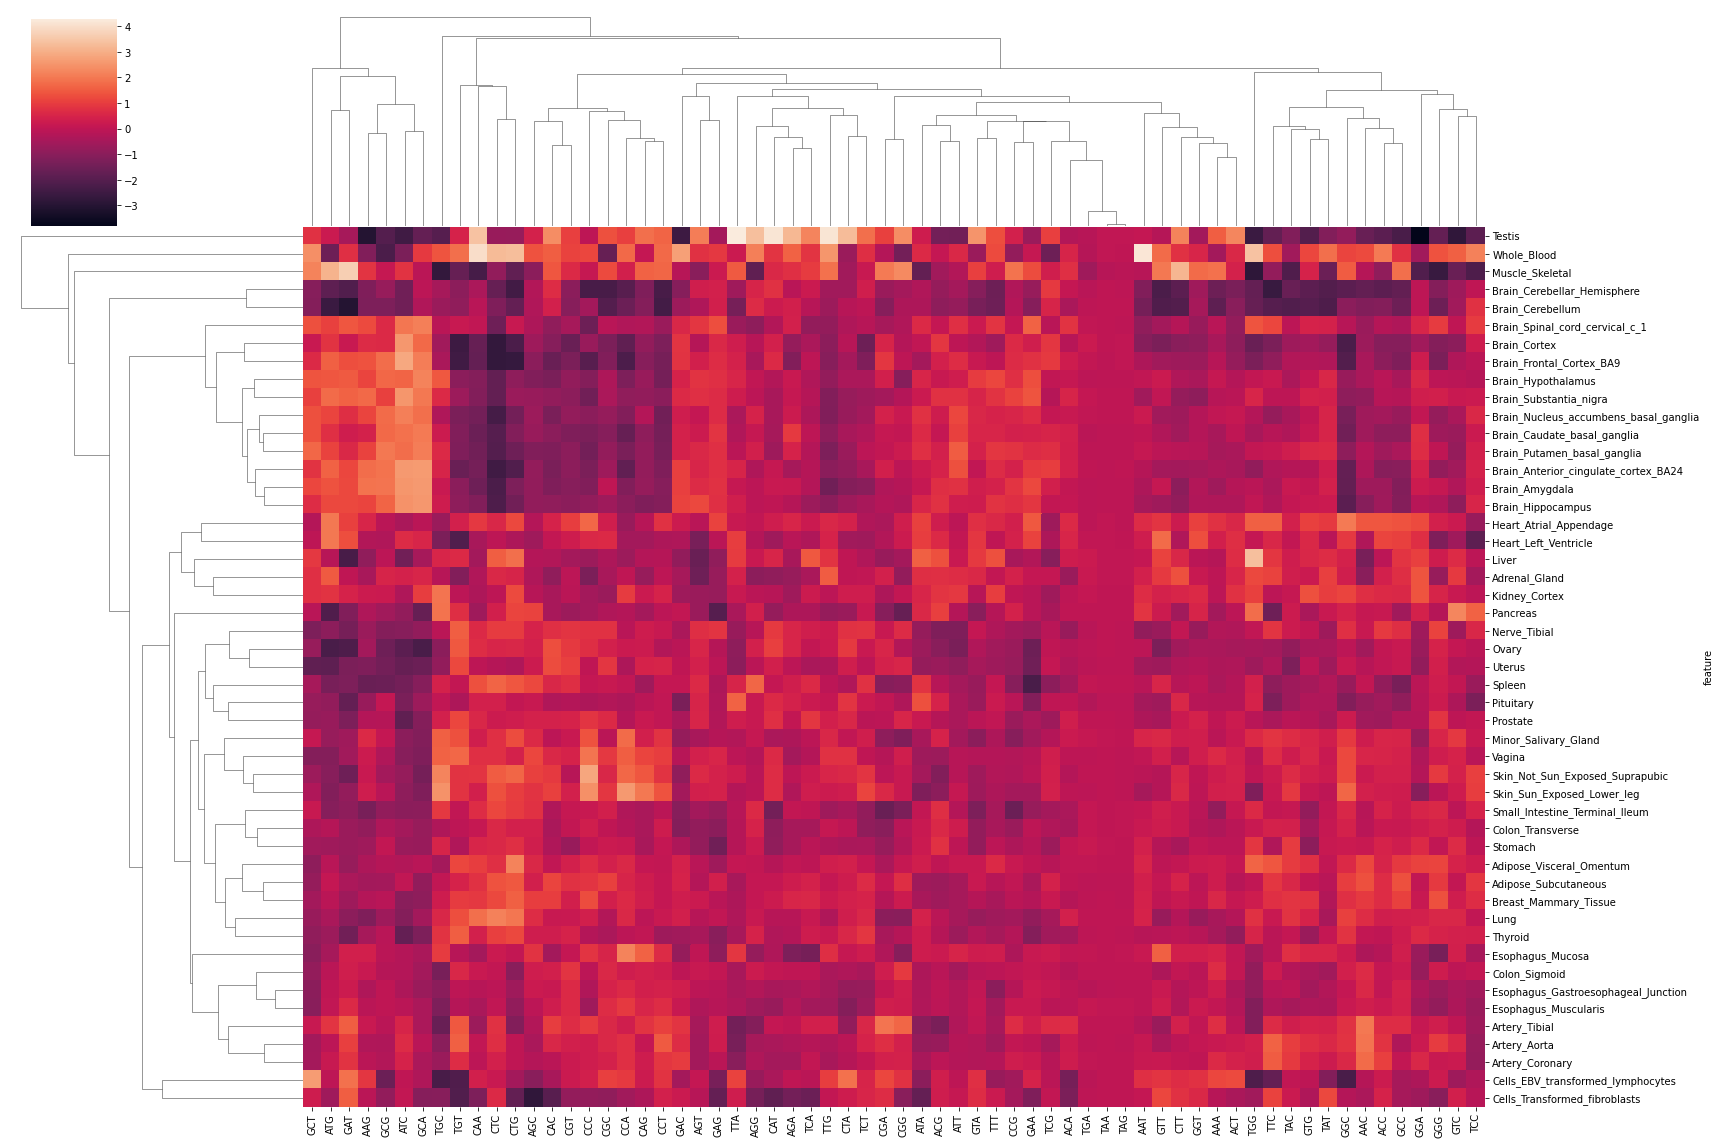

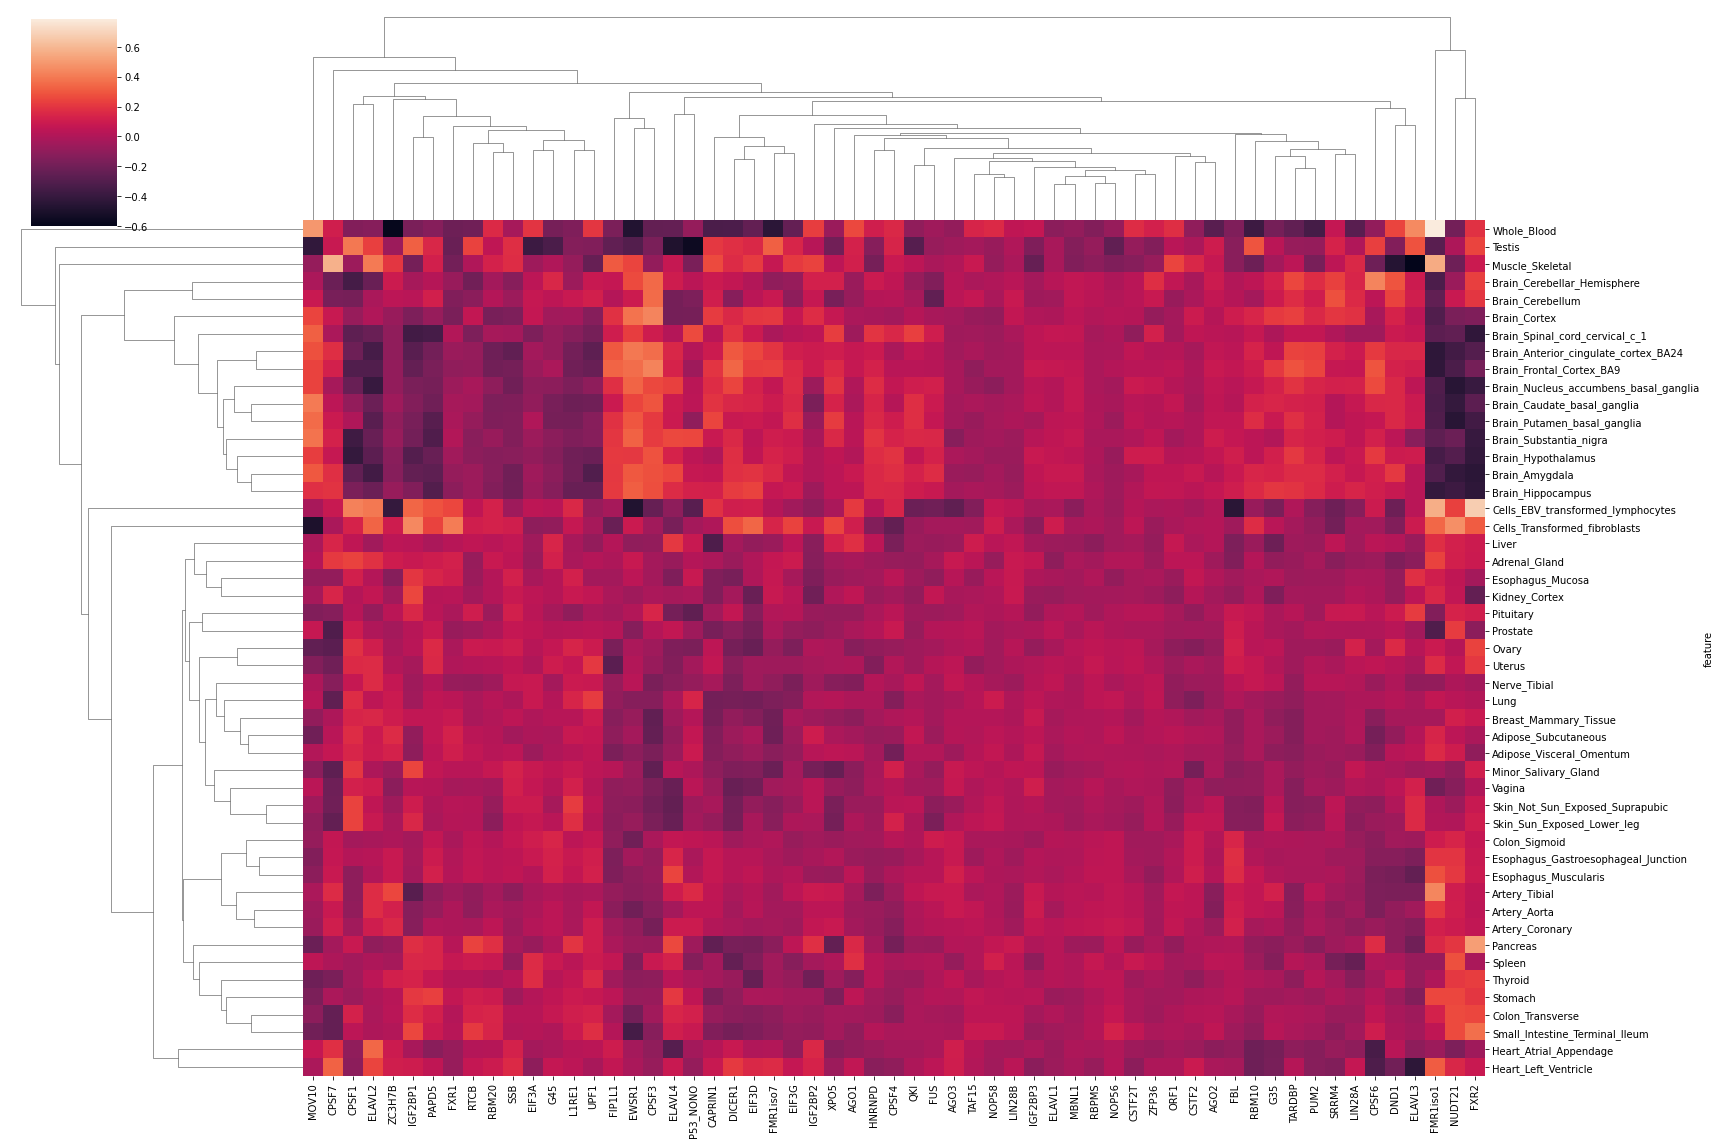

In [ ]:
cluster_plot_params_by_category(final_fit_results, feat_names)

The clustered heatmap further reveals

- a strong negative influence of _CPSF7_ and _ELAVL4_ in skin tissue and
- a strong negative influence of _CPSF6_ in heart tissue.

## Model 4: RBPs, Codon Frequencies & Extra Features

The final model combines the previously employed features with new ones concerning sequence lenghts as well as GC-content:

In [ ]:
feat_names = get_feat_names(["codon_freq", "rbp_score", "length", "gc_content"])
get_feat_values(data, feat_names)

AAA       AAC       AAG       AAT       ACA       ACC       ACG  \
0      0.005556  0.022222  0.055556  0.011111  0.022222  0.038889  0.005556   
1      0.036101  0.025271  0.014440  0.021661  0.010830  0.003610  0.003610   
2      0.004728  0.002364  0.044917  0.004728  0.007092  0.014184  0.002364   
3      0.023965  0.019608  0.071895  0.015251  0.013072  0.010893  0.006536   
4      0.003906  0.015625  0.050781  0.003906  0.011719  0.031250  0.013672   
...         ...       ...       ...       ...       ...       ...       ...   
11358  0.034794  0.011598  0.025773  0.021907  0.021907  0.024485  0.005155   
11359  0.019417  0.009709  0.087379  0.009709  0.009709  0.058252  0.000000   
11360  0.011142  0.022284  0.025070  0.016713  0.025070  0.013928  0.000000   
11361  0.020661  0.033058  0.033058  0.000000  0.016529  0.033058  0.004132   
11362  0.032086  0.018717  0.010695  0.018717  0.018717  0.024064  0.000000   

            ACT       AGA       AGC  ...      UPF1       G35       G45  \
0      0.011111  0.000000  0.011111  ...  0.075934  0.304871  0.262849   
1      0.018051  0.007220  0.018051  ...  0.212465  0.139636  0.303893   
2      0.002364  0.002364  0.018913  ...  0.078845  0.143686  0.205081   
3      0.008715  0.004357  0.017429  ...  0.149575  0.314400  0.504436   
4      0.005859  0.000000  0.035156  ...  0.215787  0.294323  0.403959   
...         ...       ...       ...  ...       ...       ...       ...   
11358  0.021907  0.012887  0.033505  ...  0.309320  0.275847  0.514541   
11359  0.000000  0.019417  0.000000  ...  0.033851  0.163344  0.419075   
11360  0.019499  0.022284  0.008357  ...  0.195718  0.238335  0.237361   
11361  0.004132  0.012397  0.033058  ...  0.334520  0.164246  0.214602   
11362  0.029412  0.013369  0.021390  ...  0.239051  0.226289  0.236632   

           XPO5  log_3_utr_length  log_5_utr_length  log_cds_length  \
0      0.198160          8.668885          7.276124        9.079485   
1      0.337837         10.505812          8.876517        9.700440   
2      0.172913          9.594325          7.426265       10.310613   
3      0.198861          9.453271          7.554589       10.428360   
4      0.424652         11.545930          7.679480       10.585901   
...         ...               ...               ...             ...   
11358  0.471805         13.476113          9.022368       11.185495   
11359  0.223508          8.581201          4.523562        8.276124   
11360  0.378352          9.388017          8.330917       10.074141   
11361  0.243445         10.750707          7.622052        9.505812   
11362  0.348496          9.337622          3.000000       10.133142   

       gc_content_5_utr  gc_content_cds  gc_content_3_utr  
0              0.837662        0.561111          0.591133  
1              0.620469        0.498195          0.414315  
2              0.836257        0.648542          0.584197  
3              0.775401        0.530864          0.504286  
4              0.720588        0.630859          0.525928  
...                 ...             ...               ...  
11358          0.668593        0.525773          0.358873  
11359          0.636364        0.611650          0.481675  
11360          0.607477        0.455896          0.325859  
11361          0.739796        0.517906          0.633566  
11362          0.571429        0.467023          0.416409  

[11363 rows x 129 columns]

### Fitting

# Evaluating model with alpha = 0
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is -0.0694835971934352
Max R^2 across tissues across folds is 0.13978394836488572


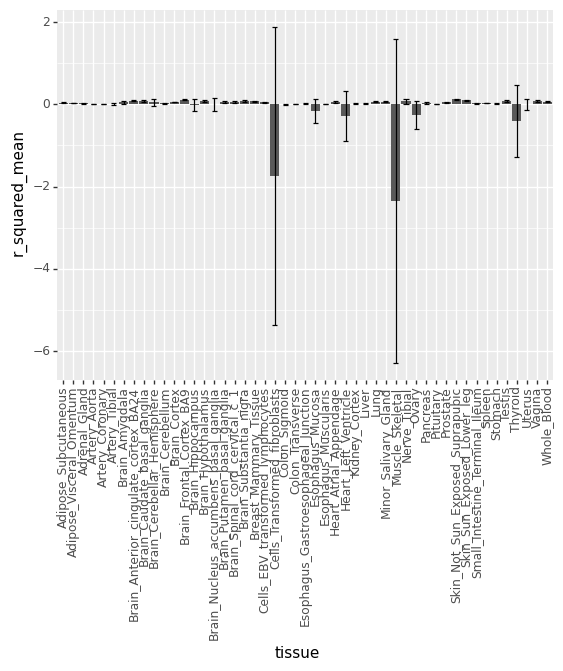

<ggplot: (8783982075109)>

# Evaluating model with alpha = 1e-05
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.052043779244889475
Max R^2 across tissues across folds is 0.14355674349455738


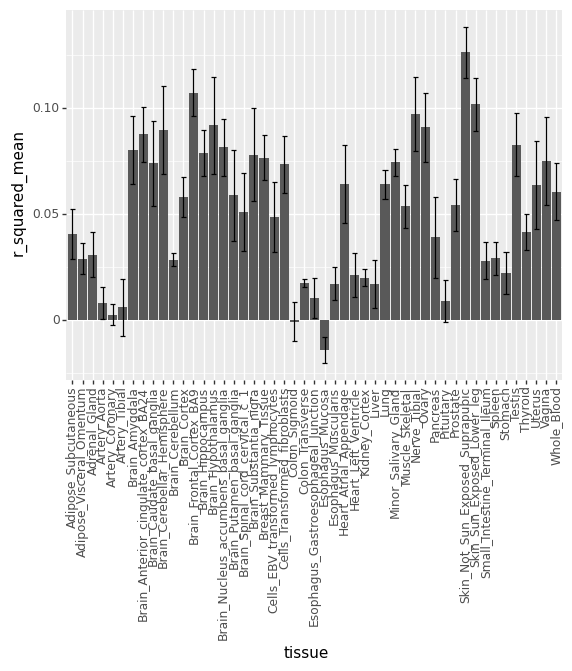

<ggplot: (8783981314017)>

# Evaluating model with alpha = 5e-05
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.05473984514524813
Max R^2 across tissues across folds is 0.14804800449341948


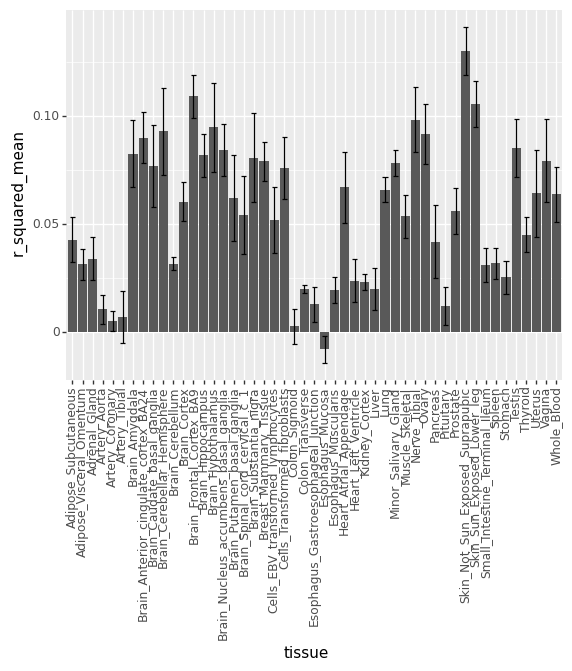

<ggplot: (8783981811469)>

# Evaluating model with alpha = 0.0001
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.05506860086537012
Max R^2 across tissues across folds is 0.14973523449489834


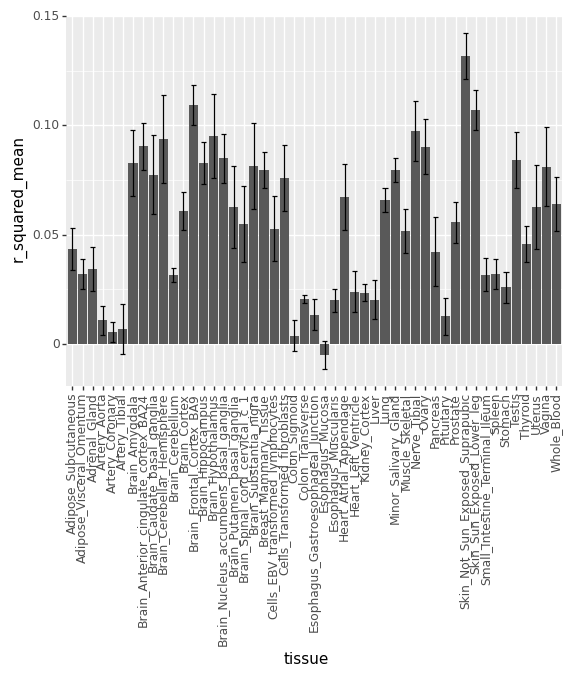

<ggplot: (8783982589405)>

# Evaluating model with alpha = 0.0005
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.05214618842976823
Max R^2 across tissues across folds is 0.14965011929944705


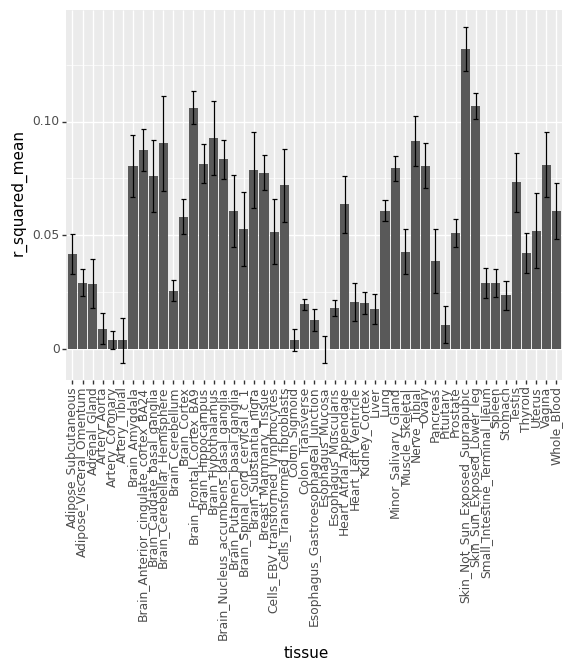

<ggplot: (8783981830121)>

# Evaluating model with alpha = 0.001
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.05034334678197939
Max R^2 across tissues across folds is 0.14819636067101272


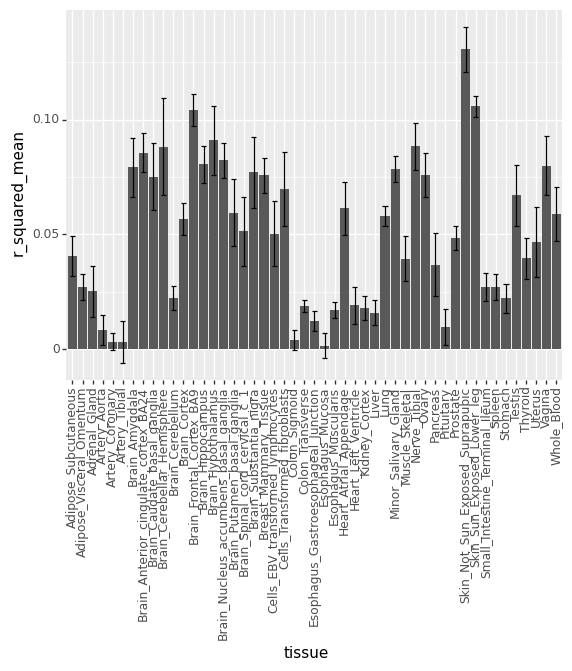

<ggplot: (8783981913525)>

# Evaluating model with alpha = 0.005
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.04679810325255171
Max R^2 across tissues across folds is 0.1418514766211818


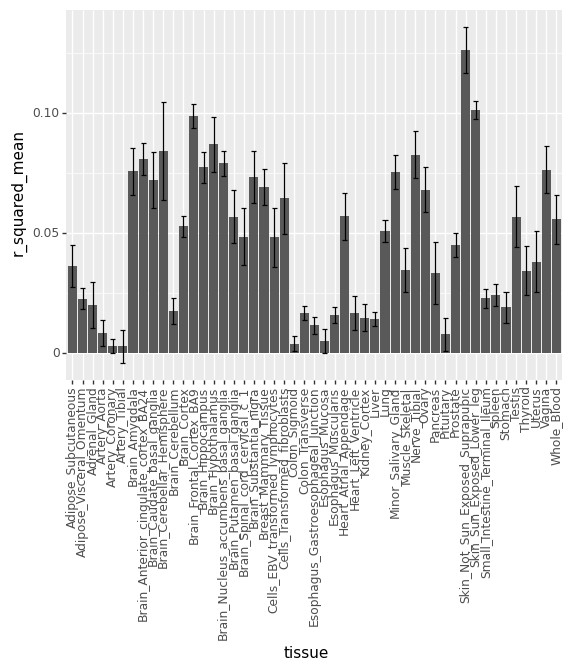

<ggplot: (8783981701429)>

# Evaluating model with alpha = 0.01
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Mean R^2 across tissues across folds is 0.044783605987103736
Max R^2 across tissues across folds is 0.13728214827057528


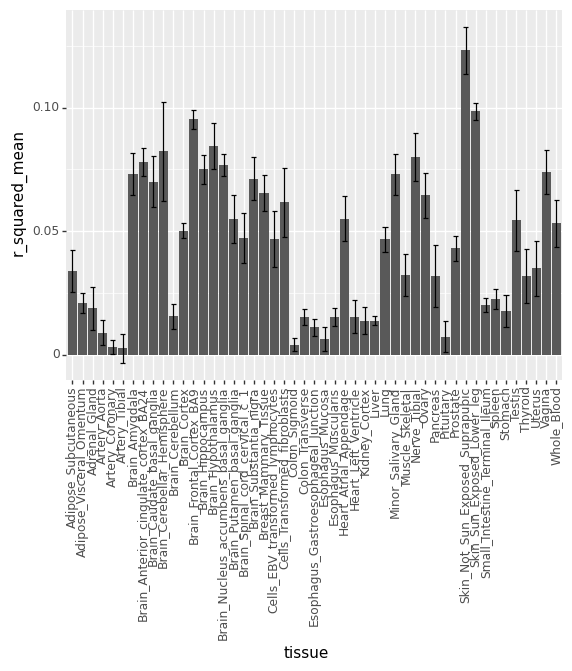

<ggplot: (8783981030777)>

# Evaluating model with alpha = 0.05
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Mean R^2 across tissues across folds is 0.037893420898921996
Max R^2 across tissues across folds is 0.12337815915109007


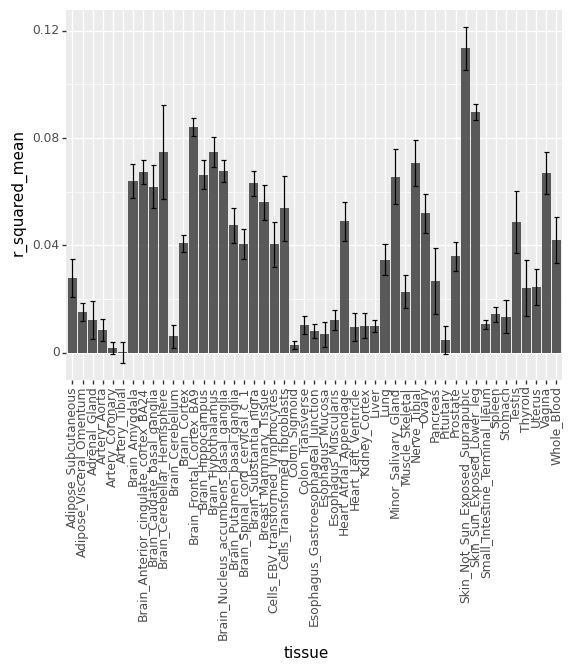

<ggplot: (8783981963461)>

# Best model: alpha = 5e-05 R^2 = 0.060648628872540446


In [ ]:
final_fit_results, final_r_squared_list = evaluate_alphas(feat_names, cv_folds, alphas)

The best $\alpha$ value considering all available features was $\alpha = 0.0001$, which lead to a mean $R^2$ across tissues across folds of $0.055069$ and a max $R^2$ across tissues across folds of $0.149735$.

Thus, the model again improved upon all previous ones.

Comparing this model's performance against the baseline model:

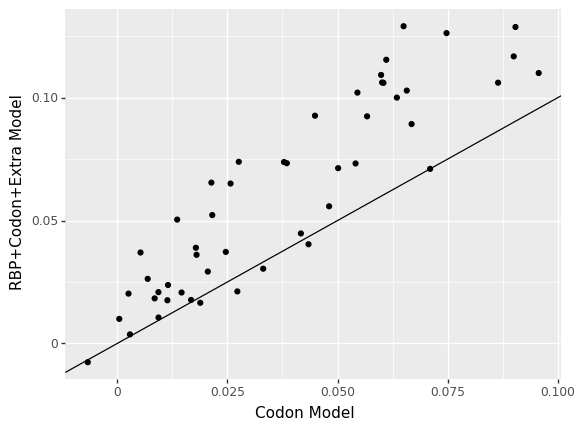

<ggplot: (8783988795489)>


In [ ]:
plot_r_squared_against(final_r_squared_list_baseline, final_r_squared_list, "Codon Model", "RBP+Codon+Extra Model")

### Interpretation

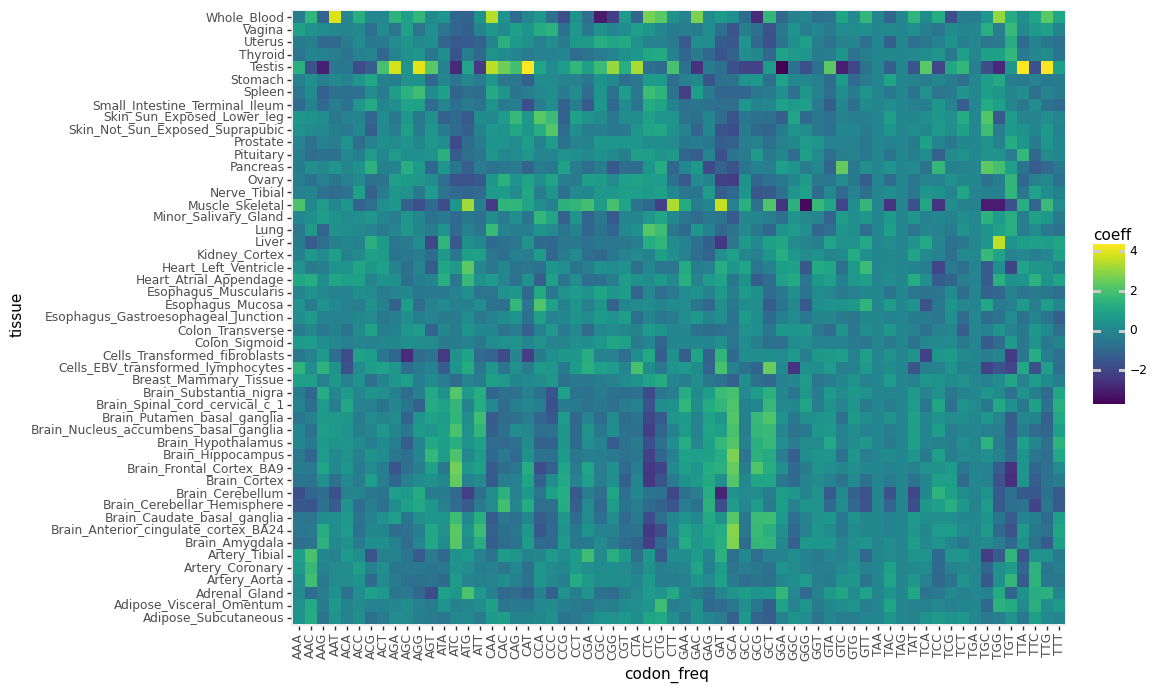

<ggplot: (8783982554801)>


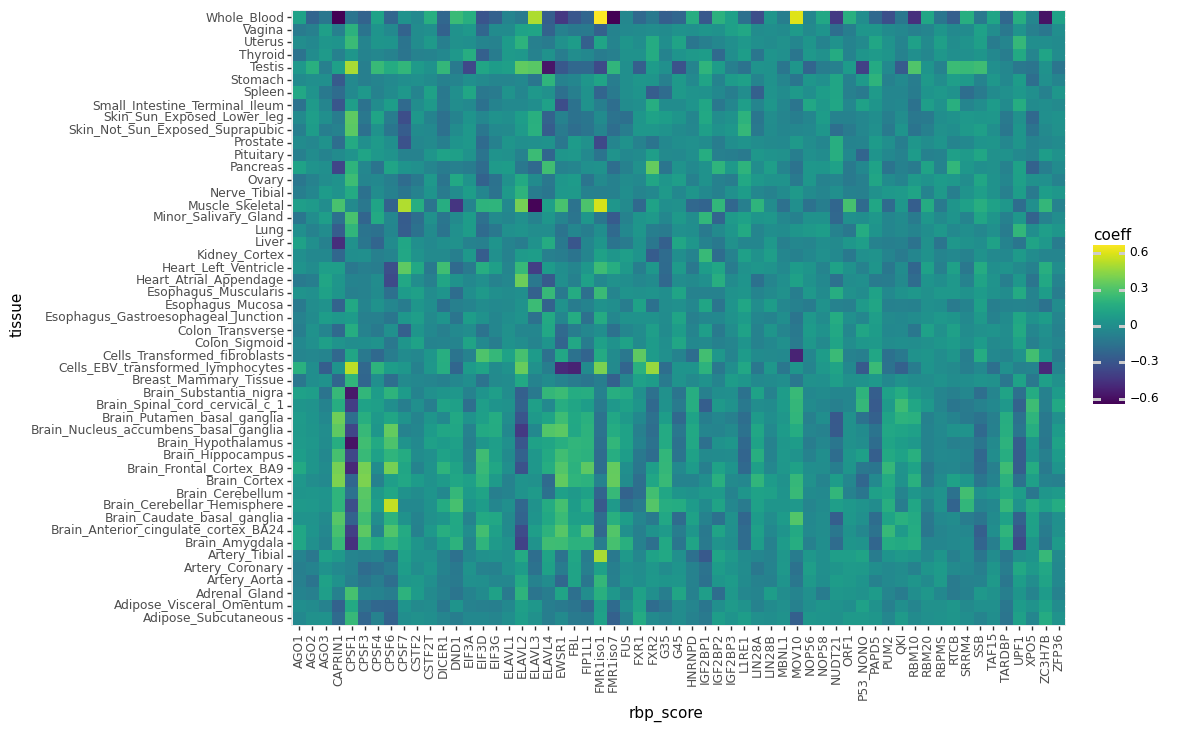

<ggplot: (8783981933149)>


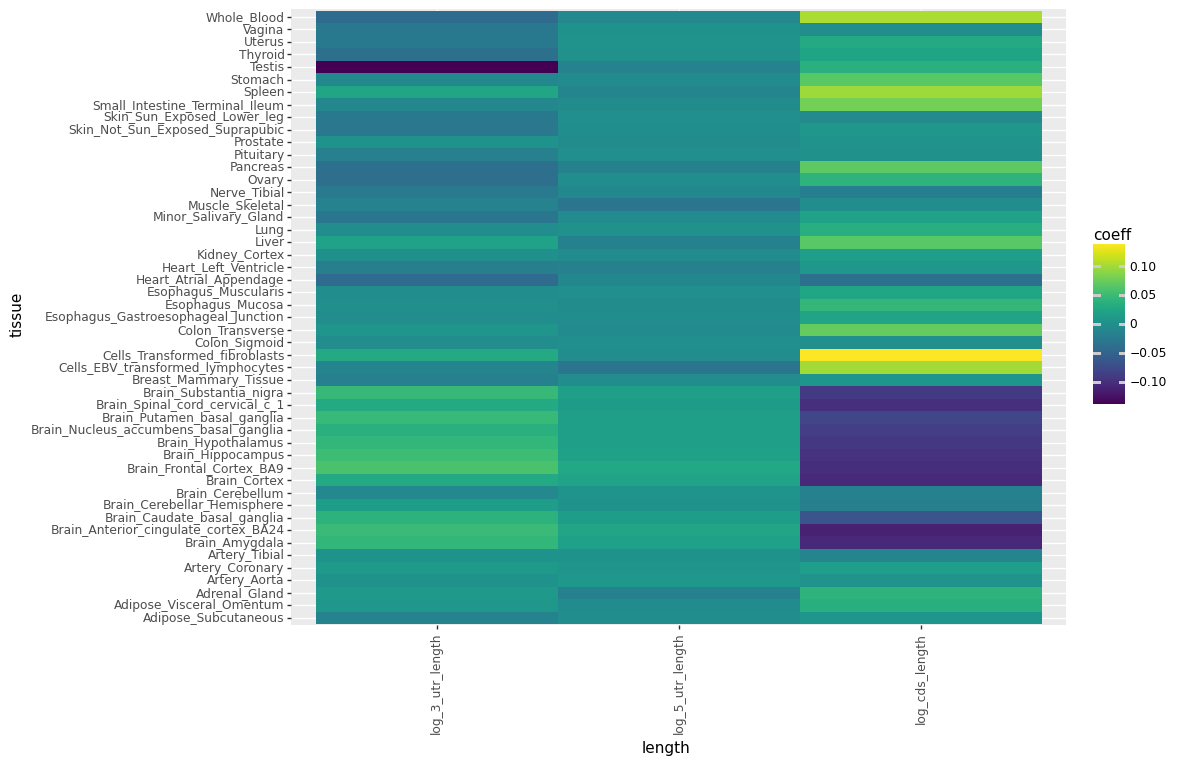

<ggplot: (8783988342745)>


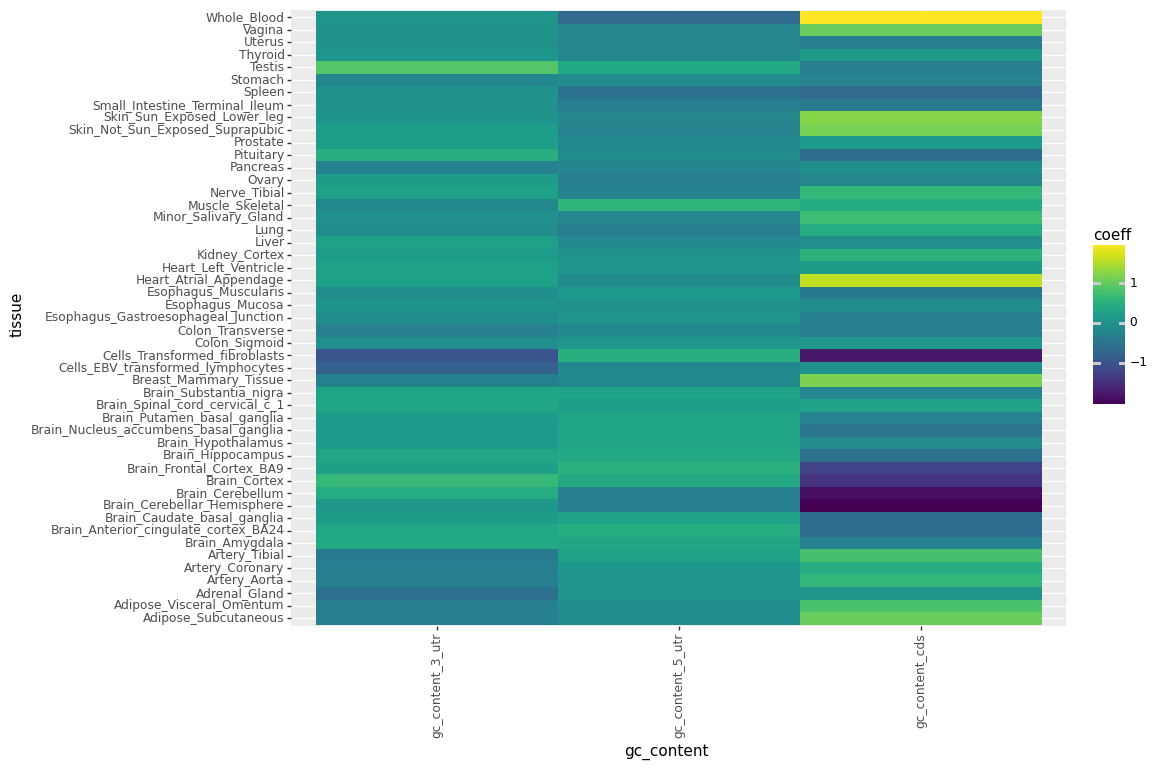

<ggplot: (8783982519745)>


In [ ]:
plot_params_by_category(final_fit_results, feat_names)

Some interesting findings in this visualization of contributions are:

There's a positive influence in brain tissues of RBPs:
- CAPRIN1
- CPSF3
- CPSF6
- FMR1iso7

And a negative influence in brain tissues of:
- _CPSF1_ and _ELAVL2_

These features had a highly negative influence in brain tissues, but also a highly positive one in some other tissues:
- log_cds_length
- gc_content_cds

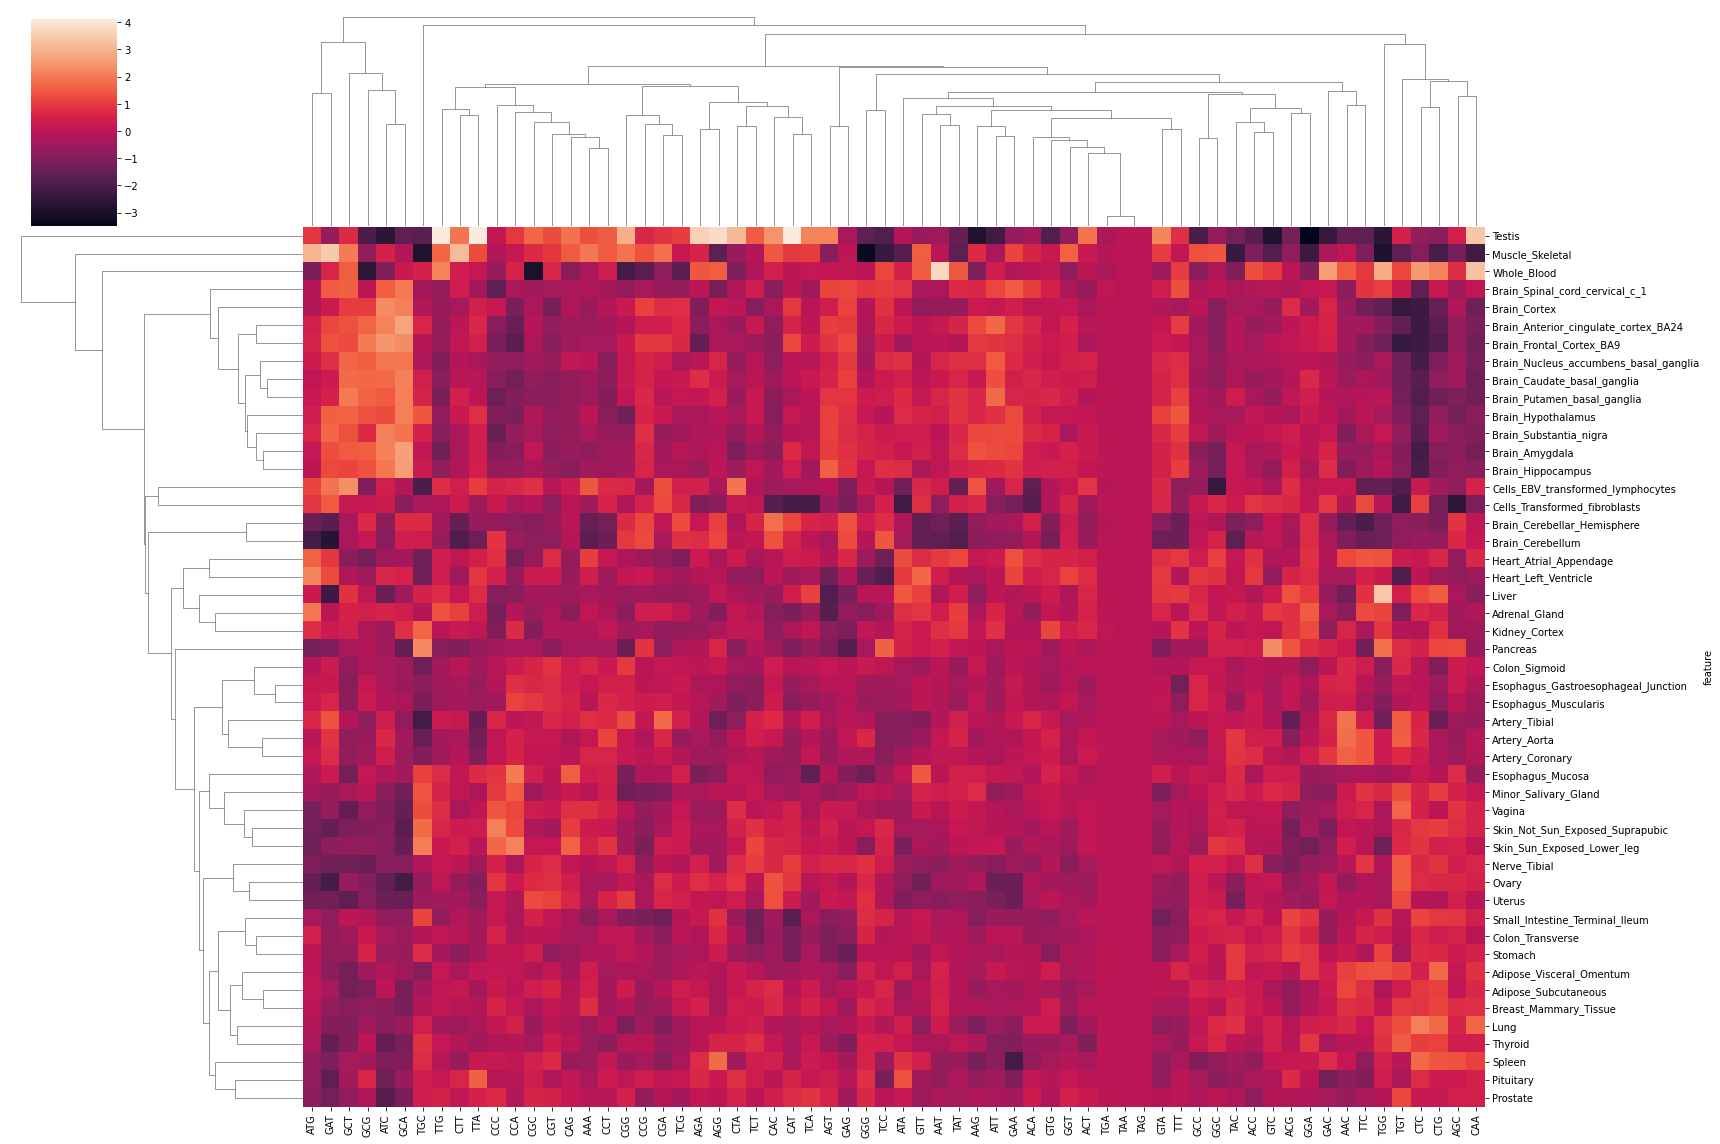

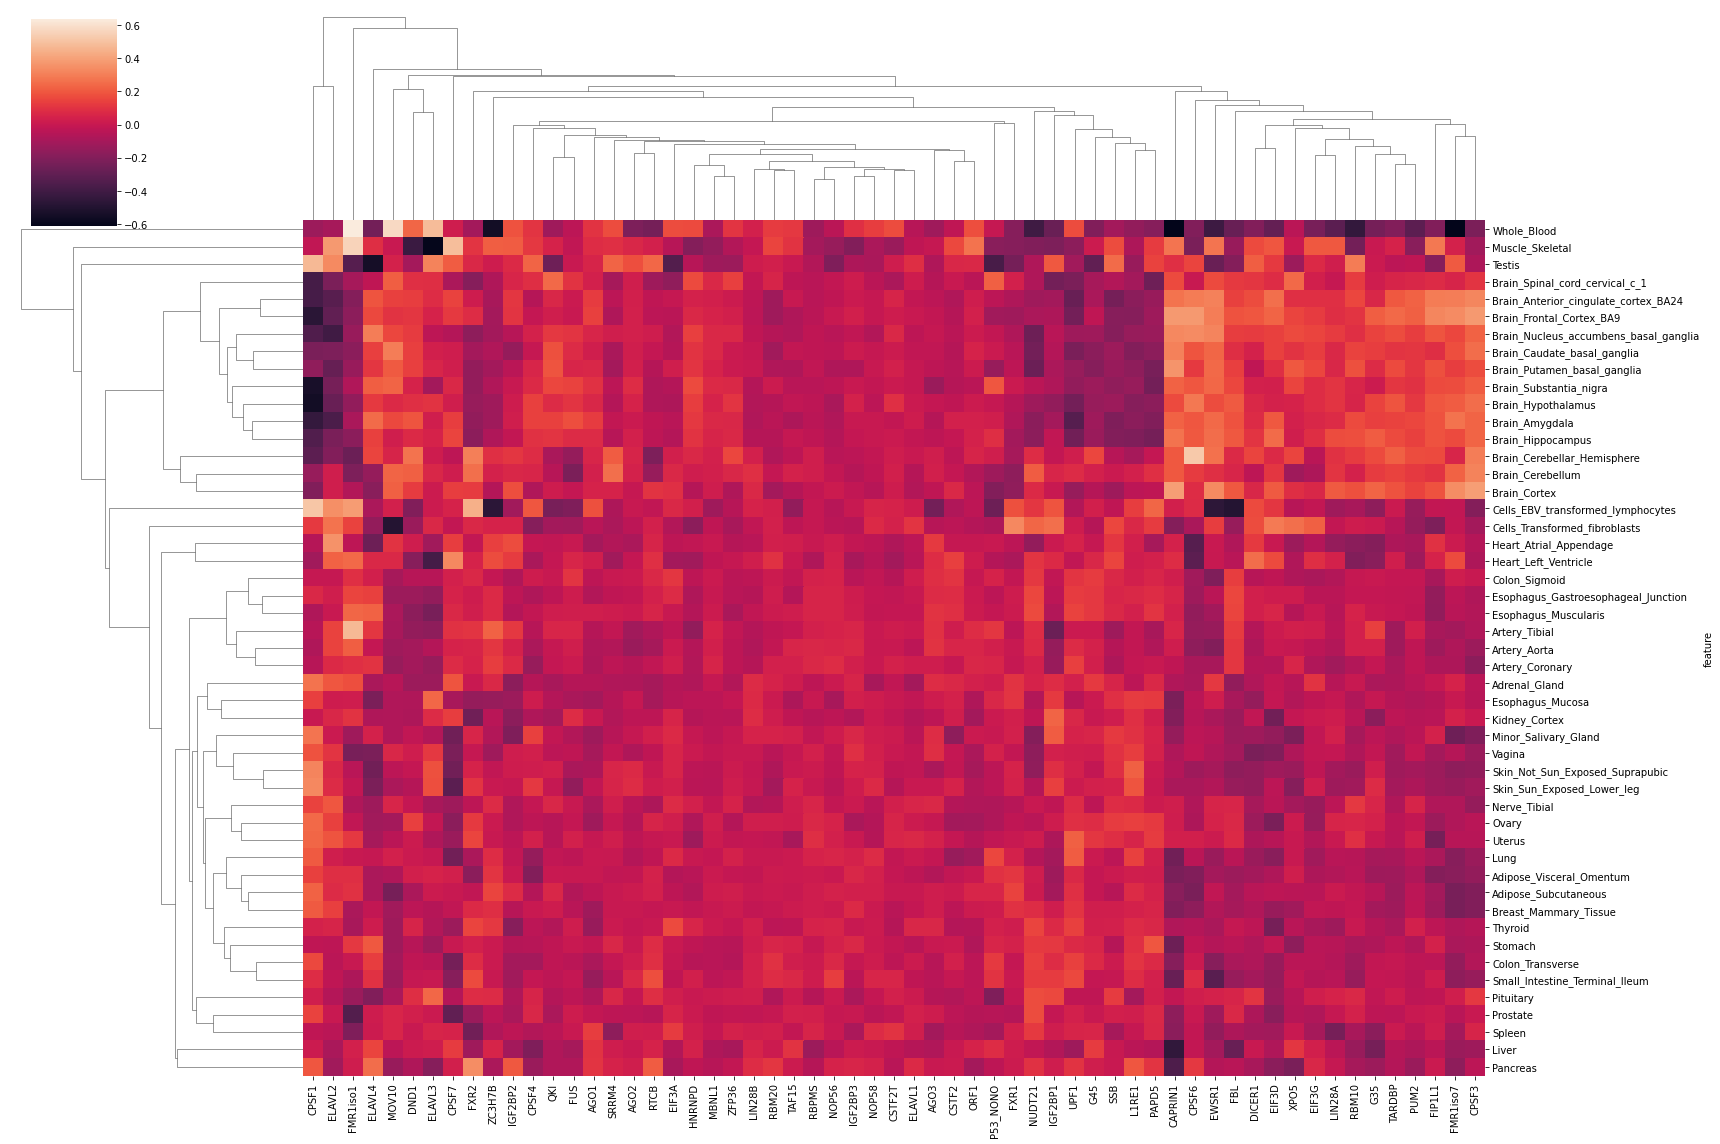

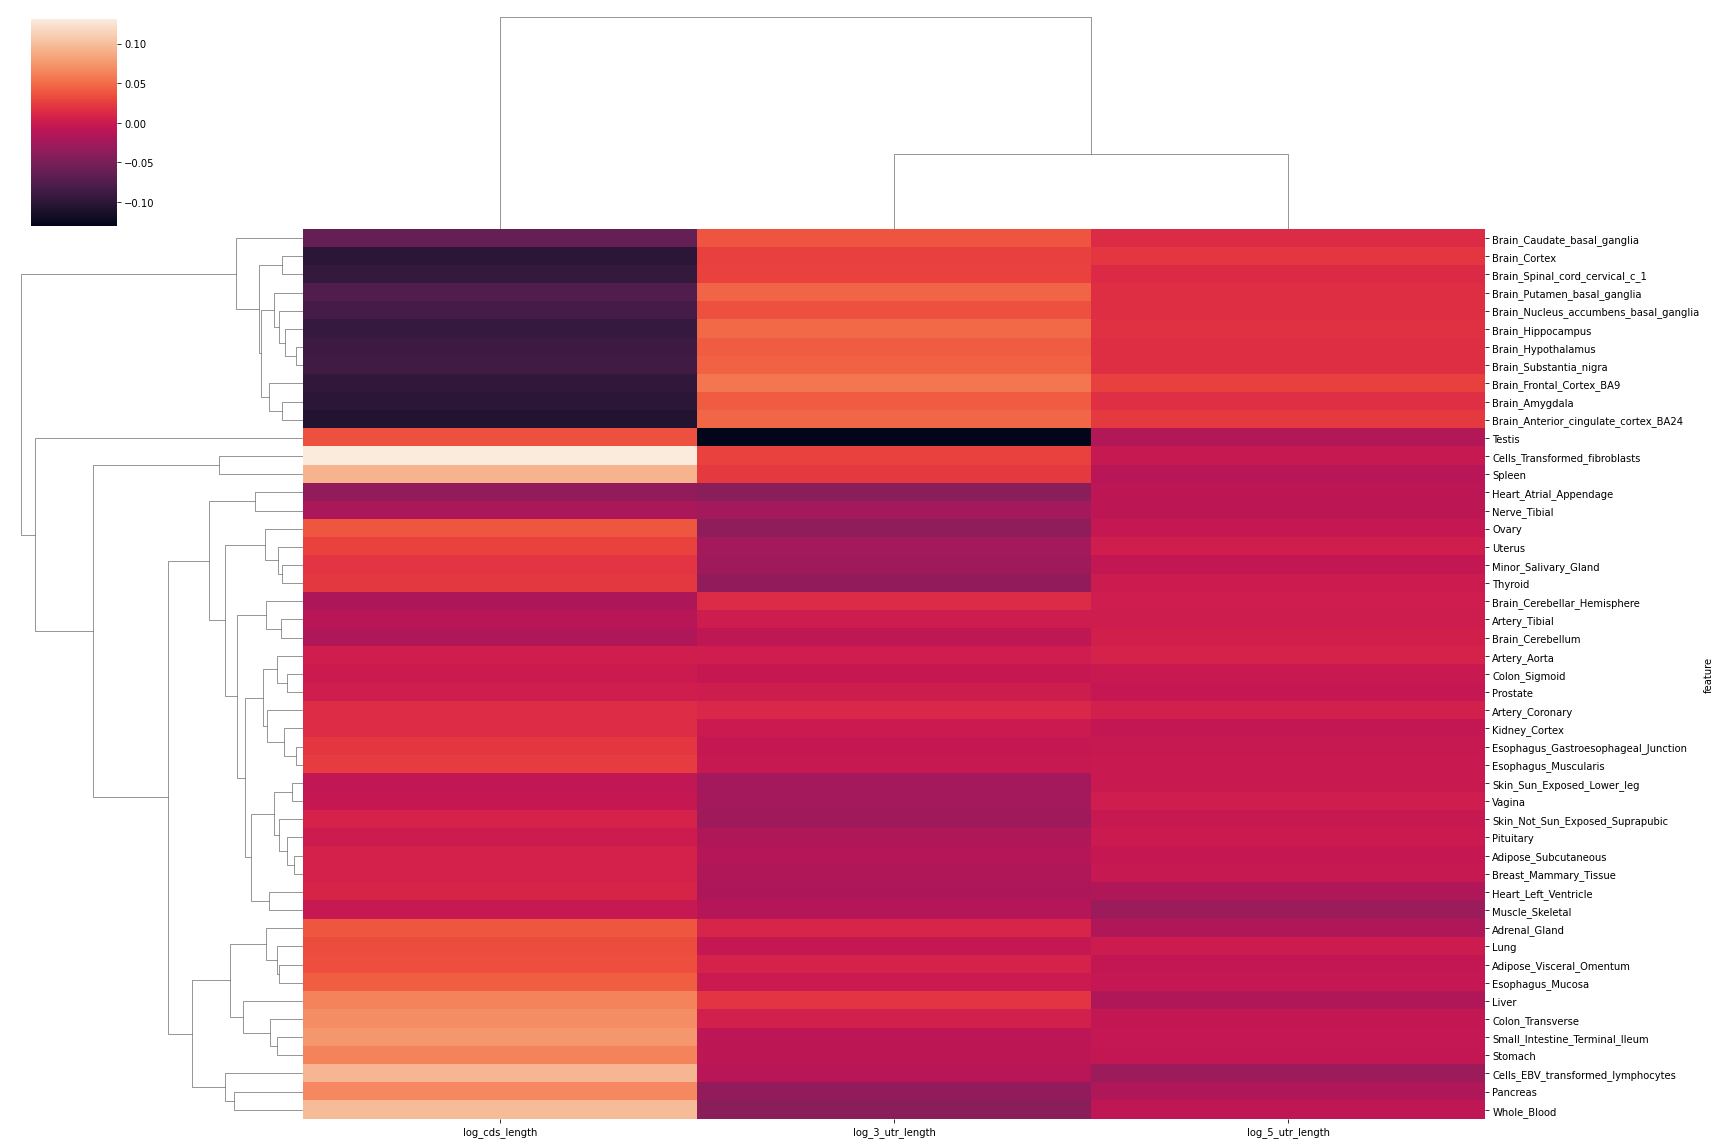

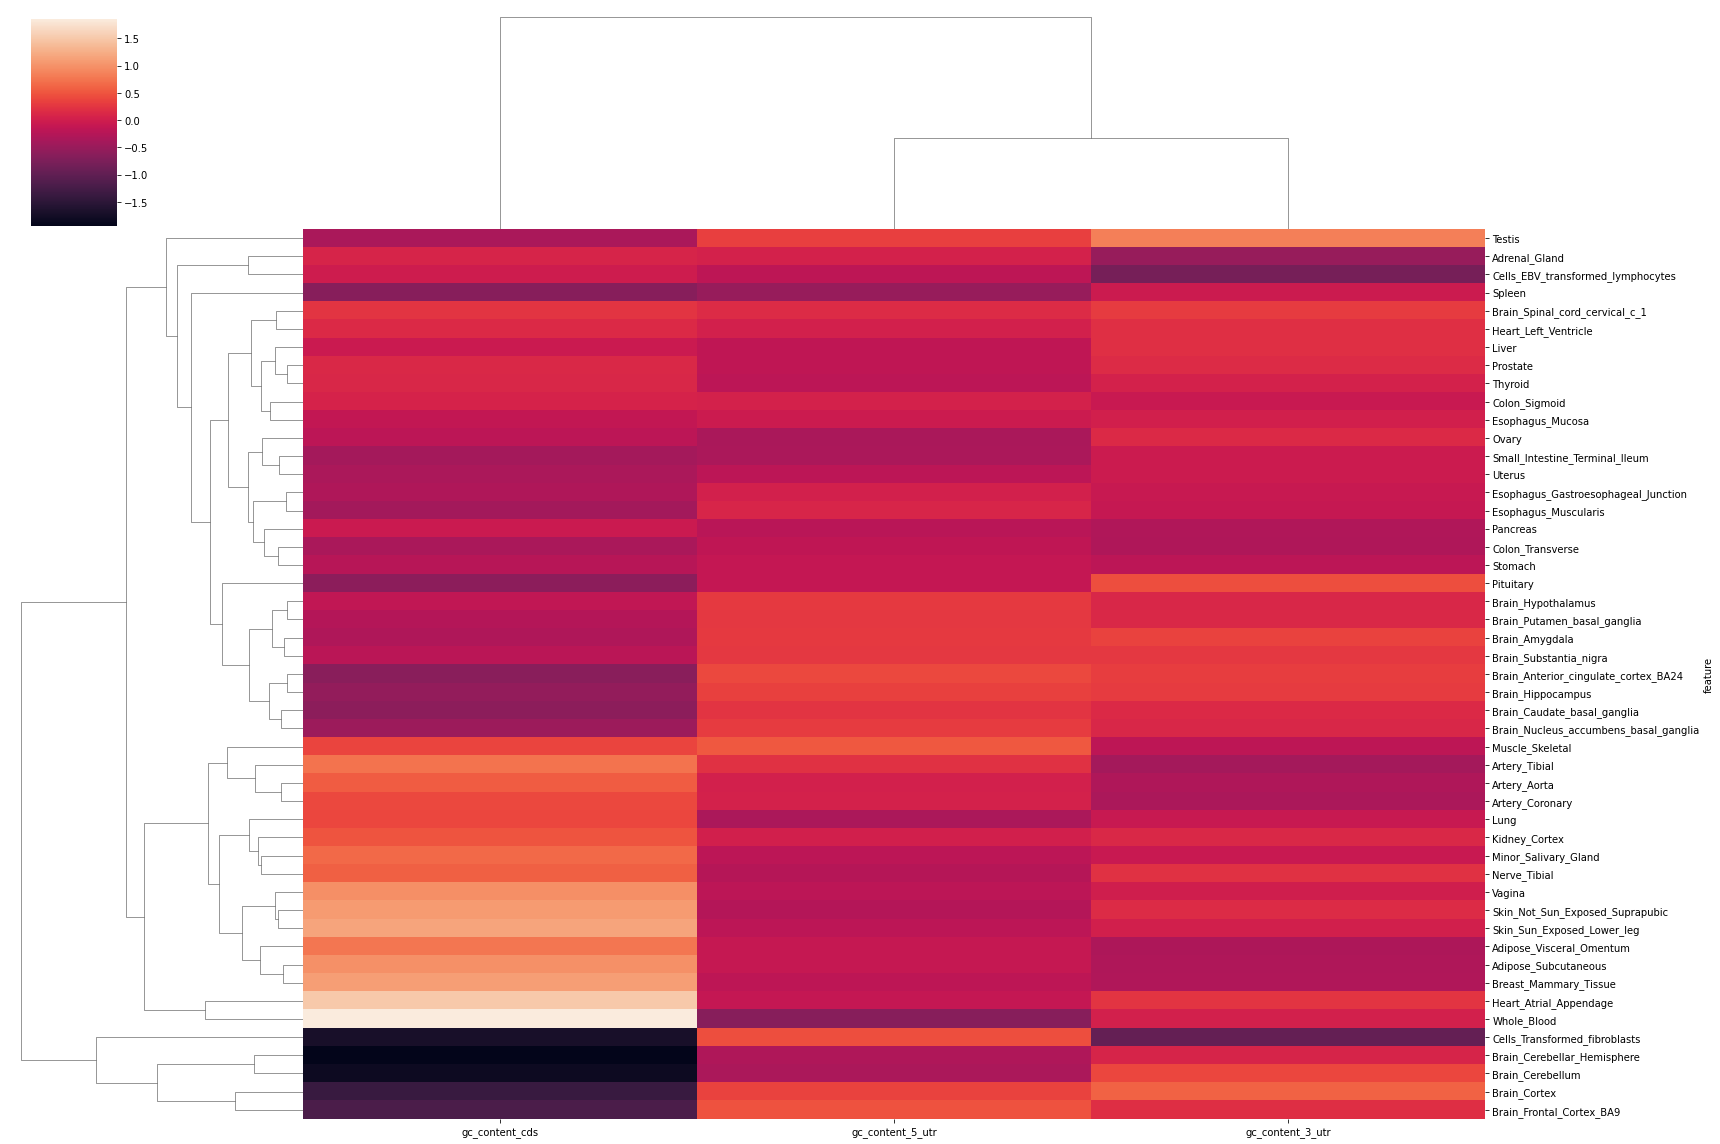

In [ ]:
cluster_plot_params_by_category(final_fit_results, feat_names)

The clustered heatmap further revealed:
- a strong negative influence of _CAPRIN1_ in liver and pancreas tissue and
- a strong negative influence of _CPSF6_ in heart tissue.

# Interpretation of Results

Most consistent observations could be found across the brain tissues, probably because there was a high amount of tissue types stemming from the brain in the data.

## Codon Frequencies

The interpretation of the model utilizing only codon frequencies is difficult, as codon frequencies are colinear and thus the learned coefficient for a single feature doesn't directly correspond to its importance in the model.

One interesting observance is that the stop codons _TAA, TAG_ and _TGA_ have almost no influence on half-life in any tissue.
One would expect that, as stop codon frequency is corellated with sequence length, and sequence length does have an influence on mRNA half-life, this would be reflected in the models.
However, this was not the case.
This can be explained by looking at the nature of the outcome variables.
The outcome variables in all models are relative measures of half-life, i.e. deviations from the mean half-life across tissue types.
Thus, sequence length, and with it stop codon frequency, doesn't influence half-life in this approach.

## RNA-binding Proteins

In the Interpretation sections of the different models and based on the plotted heatmaps, we made several predictions of which RBPs should be prevalent in specific tissue types with a higher concentration.

By browsing the [TISSUES Tissue Expression Database](https://tissues.jensenlab.org/About), we can now check these predictions against the literature.
The TISSUES database offers confidence scores from 1 to 5 for the expression of genes in different tissue types.
It employs different sources for tissue associations of genes, namely "Knowledge", which is manually curated knowledge from UniProtKB, "Experiments" and "Text mining".
In the validation process of our predictions, only the "Knowledge" and "Experiments" scores were considered and listed.

### Predictions of Model 2
- Brain
  + NUDT21: 4/5 Knowledge, 5/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000300291)
  + IGF2BP1: no supportive literature found
  + CPSF1: 3/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000484669)
  + TARDBP: 4/5 Knowledge, 5/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000240185)
- Skin
  + RBM20: no supportive literature found

### Predictions of Model 3
- Brain
  + CPSF3: 4/5 Knowledge, 5/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000238112)
  + EWSR1: 4/5 Knowledge, 5/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000400142)
  + MOV10: 4/5 Knowledge, 4/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000399797)
  + CPSF1: 3/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000484669)
  + ELAVL2: 4/5 Knowledge, 2/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000380479)
  + FMR1iso1: 4/5 Knowledge, 3/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000359506)
  + FXR2: 4/5 Knowledge, 3/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000250113)
  + NUDT21: 4/5 Knowledge, 5/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000300291)
- Skin
  + CPSF7: 2/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000345412)
  + ELAVL4: no supportive literature found
- Heart
  + CPSF6: 4/5 Knowledge, 2/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000266679)

### Predictions of Model 4
- Brain
  + CAPRIN1: 5/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000340329)
  + CPSF3: 4/5 Knowledge, 5/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000238112)
  + CPSF6: 4/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000266679)
  + FMR1iso1: 4/5 Knowledge, 3/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000359506)
  + CPSF1: 3/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000484669)
  + ELAVL2: 4/5 Knowledge, 2/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000380479)
- Liver & Pancreas
  + CAPRIN1: 4/5 Liver Knowledge, 3/5 Liver Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000340329)
- Heart
  + CPSF6: 2/5 Experiments, [Reference](https://tissues.jensenlab.org/Entity?figures=tissues_body_%&knowledge=10&experiments=10&textmining=10&homologs=10&type1=9606&type2=-25&id1=ENSP00000266679)

# Conclusion

Most predictions of increased occurence of RBPs in specific tissue types could be supported by the literature.
These results lead to the conclusion that by expanding this technique on other RBPs and by obtaining more predictions from the heatmaps or other approaches, e.g. extracting predictions using absolute coefficient values per tissue, might result in the discovery of new expression patterns of RBPs in tissue types.

These predictions could then be confirmed experimentally.